In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

In [7]:
# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [8]:
# prompt: carga de datos desde google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Specify the file path in your Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/BBDD_ParaInciar_MakDigital.xlsx'  # Replace 'your_file.csv' with the actual file name and path

In [10]:
# Creación de un dataframe simulado basado en la descripción del conjunto de datos
np.random.seed(42)
n_samples = 16683

In [11]:
# Simulación de variables demográficas
edad = np.random.normal(40, 12, n_samples).astype(int)
edad = np.clip(edad, 18, 85)  # Limitamos la edad entre 18 y 85 años

# Simulación de variables categóricas
sexo = np.random.choice(['MASCULINO', 'FEMENINO'], n_samples)
estado_civil = np.random.choice(['CASADO', 'UNION LIBRE', 'SOLTERO', 'DIVORCIADO', 'VIUDO'],
                                n_samples, p=[0.4, 0.15, 0.3, 0.1, 0.05])

# Simulación de variables financieras (con correlación)
base_limite = np.random.lognormal(8, 1, n_samples)
maxima_tarjeta = (base_limite * (0.8 + 0.4 * np.random.random(n_samples))).astype(int)
maxima_tarjeta = np.clip(maxima_tarjeta, 500, 25000)

# El consumo máximo está correlacionado con el límite pero siempre es menor
ratio_consumo = np.random.beta(2, 3, n_samples)  # Beta distribution para ratios entre 0 y 1
maximo_consumo = (maxima_tarjeta * ratio_consumo).astype(int)

# Variables geográficas
paises = ['ECUADOR'] * n_samples
provincias = np.random.choice(['PICHINCHA', 'GUAYAS', 'AZUAY', 'MANABI', 'LOJA'],
                              n_samples, p=[0.35, 0.30, 0.15, 0.12, 0.08])

# Ciudades condicionadas a provincias
ciudades = []
for prov in provincias:
    if prov == 'PICHINCHA':
        ciudades.append(np.random.choice(['QUITO', 'SANGOLQUI', 'CAYAMBE'], p=[0.8, 0.15, 0.05]))
    elif prov == 'GUAYAS':
        ciudades.append(np.random.choice(['GUAYAQUIL', 'DURAN', 'SAMBORONDON'], p=[0.75, 0.15, 0.1]))
    elif prov == 'AZUAY':
        ciudades.append(np.random.choice(['CUENCA', 'GUALACEO'], p=[0.9, 0.1]))
    elif prov == 'MANABI':
        ciudades.append(np.random.choice(['MANTA', 'PORTOVIEJO', 'CHONE'], p=[0.45, 0.45, 0.1]))
    else:  # LOJA
        ciudades.append(np.random.choice(['LOJA', 'CATAMAYO'], p=[0.9, 0.1]))


In [12]:
# Generación del perfil de riesgo basado en características financieras y demográficas
# Creamos un score compuesto para determinar el perfil
score_riesgo = (ratio_consumo * 0.6 + (edad < 30) * 0.2 + (estado_civil == 'SOLTERO') * 0.1 +
                np.random.random(n_samples) * 0.1)

perfil_riesgo = ['PERFIL BAJO'] * n_samples
perfil_riesgo = [('PERFIL ALTO' if s > 0.7 else
                  'PERFIL MEDIO' if s > 0.4 else
                  'PERFIL BAJO') for s in score_riesgo]


In [13]:
# Creación del dataframe
df = pd.DataFrame({
    'IDENTIFICACION': ['ID_' + str(i) for i in range(1, n_samples + 1)],
    'EDAD': edad,
    'sexo': sexo,
    'estado_civil': estado_civil,
    'MAXIMA_TARJETA': maxima_tarjeta,
    'MAXIMO_CONSUMO': maximo_consumo,
    'PAIS_DOM_CAL_DAT': paises,
    'PROV_DOM_CAL_DAT': provincias,
    'CIUDAD_DOM_CAL_DAT': ciudades,
    'PERFILRIESGOENDEUDAMIENTO': perfil_riesgo
})

In [14]:
# 2. Exploración inicial de datos
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas del dataset:")
print(df.head())

Dimensiones del dataset: (16683, 10)

Primeras filas del dataset:
  IDENTIFICACION  EDAD       sexo estado_civil  MAXIMA_TARJETA  \
0           ID_1    45  MASCULINO  UNION LIBRE             676   
1           ID_2    38  MASCULINO        VIUDO            3231   
2           ID_3    47   FEMENINO  UNION LIBRE            1358   
3           ID_4    58  MASCULINO      SOLTERO            1018   
4           ID_5    37   FEMENINO      SOLTERO            6063   

   MAXIMO_CONSUMO PAIS_DOM_CAL_DAT PROV_DOM_CAL_DAT CIUDAD_DOM_CAL_DAT  \
0             314          ECUADOR            AZUAY             CUENCA   
1            1015          ECUADOR           GUAYAS          GUAYAQUIL   
2             312          ECUADOR           MANABI         PORTOVIEJO   
3             324          ECUADOR        PICHINCHA              QUITO   
4            1520          ECUADOR        PICHINCHA              QUITO   

  PERFILRIESGOENDEUDAMIENTO  
0               PERFIL BAJO  
1               PERFIL BAJO  
2 

In [15]:
print("\nInformación de las variables:")
print(df.info())


Información de las variables:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16683 entries, 0 to 16682
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   IDENTIFICACION             16683 non-null  object
 1   EDAD                       16683 non-null  int64 
 2   sexo                       16683 non-null  object
 3   estado_civil               16683 non-null  object
 4   MAXIMA_TARJETA             16683 non-null  int64 
 5   MAXIMO_CONSUMO             16683 non-null  int64 
 6   PAIS_DOM_CAL_DAT           16683 non-null  object
 7   PROV_DOM_CAL_DAT           16683 non-null  object
 8   CIUDAD_DOM_CAL_DAT         16683 non-null  object
 9   PERFILRIESGOENDEUDAMIENTO  16683 non-null  object
dtypes: int64(3), object(7)
memory usage: 1.3+ MB
None


In [16]:
print("\nEstadísticas descriptivas:")
print(df.describe())



Estadísticas descriptivas:
               EDAD  MAXIMA_TARJETA  MAXIMO_CONSUMO
count  16683.000000    16683.000000    16683.000000
mean      39.717377     4724.174129     1882.947072
std       11.635387     5004.659664     2441.679456
min       18.000000      500.000000        0.000000
25%       31.000000     1498.000000      457.000000
50%       40.000000     2966.000000     1036.000000
75%       48.000000     5899.000000     2255.000000
max       85.000000    25000.000000    23004.000000


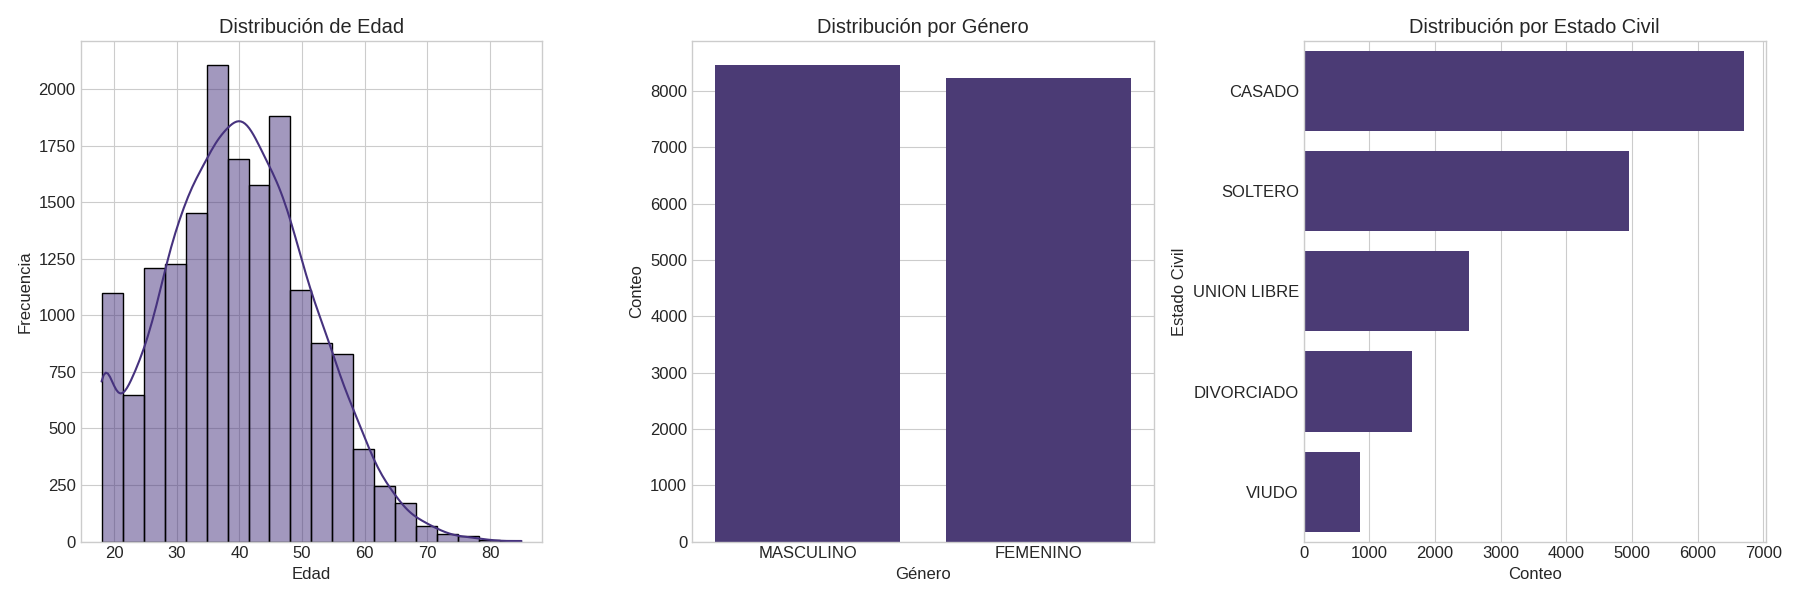

In [17]:
# 3. Análisis exploratorio de variables clave

# 3.1 Distribución de variables demográficas
plt.figure(figsize=(18, 6))

# Distribución de edades
plt.subplot(131)
sns.histplot(df['EDAD'], kde=True, bins=20)
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

# Distribución por género
plt.subplot(132)
sns.countplot(x='sexo', data=df)
plt.title('Distribución por Género')
plt.xlabel('Género')
plt.ylabel('Conteo')

# Distribución por estado civil
plt.subplot(133)
sns.countplot(y='estado_civil', data=df, order=df['estado_civil'].value_counts().index)
plt.title('Distribución por Estado Civil')
plt.xlabel('Conteo')
plt.ylabel('Estado Civil')

plt.tight_layout()
plt.savefig('demograficos.png')
plt.close()
from IPython.display import Image
display(Image('demograficos.png'))

**1. Distribución de Edad:**

* **Interpretación:** Este histograma muestra la distribución de edades en el conjunto de datos simulado.  La distribución parece más o menos normal, centrada alrededor de los 40 años, con una desviación estándar de aproximadamente 12 años.  El eje x representa la edad y el eje y muestra la frecuencia o el recuento de individuos dentro de cada grupo de edad (grupos). La curva superpuesta a las barras es una estimación de la densidad del núcleo (KDE), que proporciona una representación fluida de la distribución.  El ligero sesgo hacia la derecha sugiere que podría haber una proporción algo mayor de personas en los rangos de mayor edad en comparación con los rangos de edad más jóvenes, aunque la distribución general es bastante simétrica.  El rango de edad se ha recortado entre 18 y 85 años.

**2. Distribución por Género:**

* **Interpretación:** Este diagrama de barras muestra los recuentos de individuos 'MASCULINO' (masculino) y 'FEMENINO' (femenino) en el conjunto de datos.  Las alturas de las barras representan el número de apariciones de cada género. El gráfico muestra una distribución casi igual entre hombres y mujeres, que es el resultado de la generación aleatoria de datos que asigna a cada género la misma probabilidad (50/50).

**3. Distribución por Estado Civil (Distribución de Estado Civil):**

* **Interpretación:** Este gráfico de barras muestra la frecuencia de diferentes estados civiles ('CASADO' - Casado, 'UNION LIBRE' - Convivencia, 'SOLTERO' - Soltero, 'DIVORCIADO' - Divorciado y 'VIUDO' - Viudo).  Las barras están ordenadas en orden descendente de frecuencia.  Como los datos se generan aleatoriamente, las frecuencias no son necesariamente realistas, pero reflejan las probabilidades relativas asignadas durante el proceso de generación.  En este caso 'CASADO' es la categoría más frecuente, seguida de 'SOLTERO' (Soltero).  'UNION LIBRE' (Convivencia), 'DIVORCIADO' (Divorciado) y 'VIUDO' (Viudo) son menos frecuentes, mostrando las probabilidades definidas en el código.

**Resultados generales:**

El análisis revela las características demográficas simuladas del conjunto de datos. La edad se distribuye normalmente alrededor de los 40 años con una desviación estándar de 12 y se recorta a una edad entre 18 y 85 años. La distribución de género está casi equilibrada. El estado civil más frecuente es Casado, seguido de Soltero, siendo los demás estados menos prevalentes según las probabilidades especificadas en el código.  Es importante recordar que estos datos son sintéticos y no representan datos demográficos del mundo real. Si este código se ejecutara con datos reales de un conjunto de datos real, mostraría una instantánea precisa de la demografía.


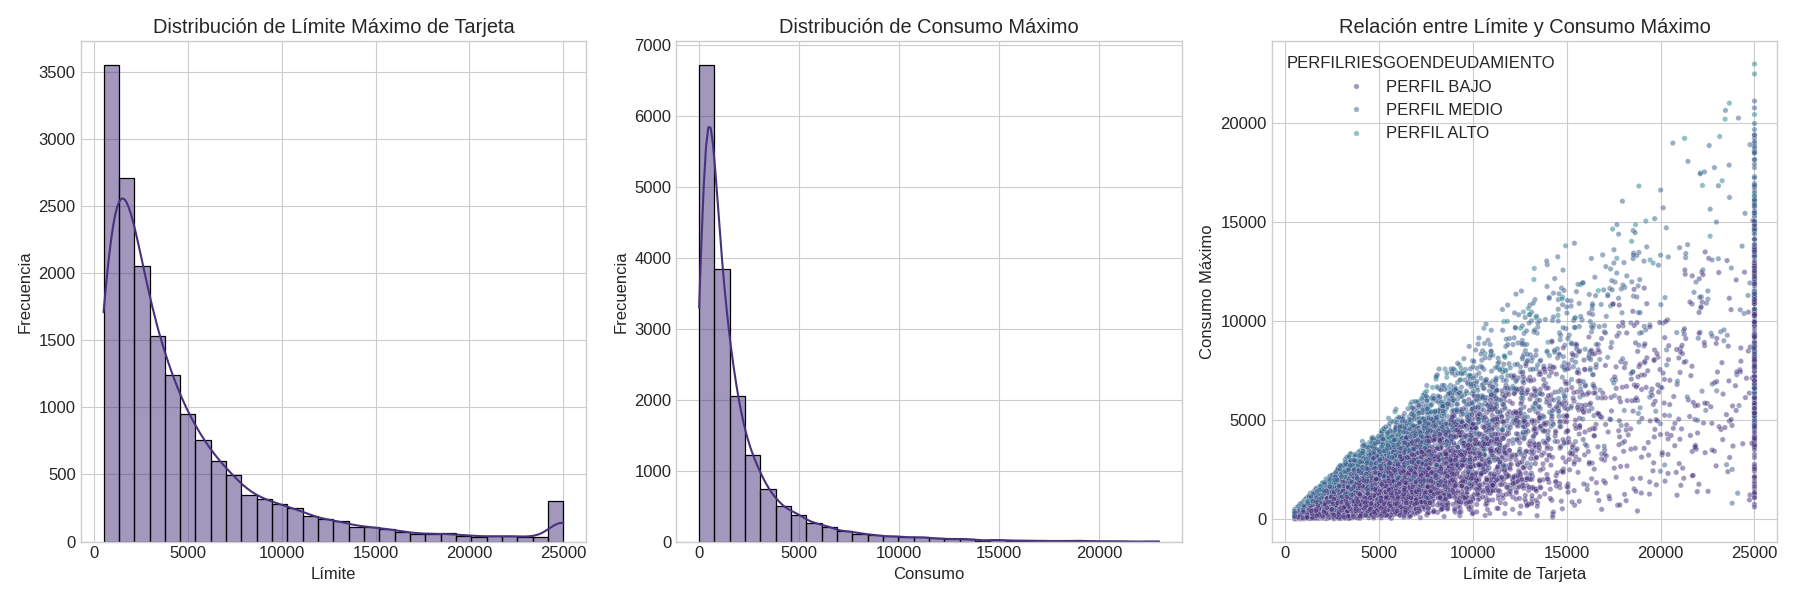

In [18]:
# 3.2 Análisis de variables financieras
plt.figure(figsize=(18, 6))

# Distribución del límite de tarjeta
plt.subplot(131)
sns.histplot(df['MAXIMA_TARJETA'], kde=True, bins=30)
plt.title('Distribución de Límite Máximo de Tarjeta')
plt.xlabel('Límite')
plt.ylabel('Frecuencia')

# Distribución del consumo máximo
plt.subplot(132)
sns.histplot(df['MAXIMO_CONSUMO'], kde=True, bins=30)
plt.title('Distribución de Consumo Máximo')
plt.xlabel('Consumo')
plt.ylabel('Frecuencia')

# Relación entre límite y consumo
plt.subplot(133)
sns.scatterplot(x='MAXIMA_TARJETA', y='MAXIMO_CONSUMO', data=df,
                hue='PERFILRIESGOENDEUDAMIENTO', alpha=0.5, s=15)
plt.title('Relación entre Límite y Consumo Máximo')
plt.xlabel('Límite de Tarjeta')
plt.ylabel('Consumo Máximo')

plt.tight_layout()
plt.savefig('financieros.png')
plt.close()
from IPython.display import Image
display(Image('financieros.png'))

#**Análisis de variables financieras**

 **1. Distribución del límite de tarjeta:**

 * **Interpretación:** Este histograma muestra la distribución de los límites máximos de las tarjetas de crédito. La distribución parece sesgada a la derecha, lo que indica que la mayoría de las personas tienen límites relativamente bajos, pero algunos individuos tienen límites mucho más altos. Esto es común en datos de tarjetas de crédito, donde los límites suelen variar significativamente entre individuos.  La curva KDE ayuda a visualizar la forma de la distribución y confirmar la asimetría hacia la derecha.


 **2. Distribución del consumo máximo:**

 * **Interpretación:** Este histograma representa la distribución de los consumos máximos en las tarjetas de crédito.  Similar al límite de la tarjeta, la distribución también parece estar sesgada a la derecha, lo que sugiere una concentración de consumos menores y algunos consumos excepcionalmente altos. La similitud con la distribución del límite de la tarjeta es esperada, ya que el consumo máximo está correlacionado con el límite.


 **3. Relación entre límite y consumo máximo:**

 * **Interpretación:** Este gráfico de dispersión muestra la relación entre el límite máximo de la tarjeta de crédito y el consumo máximo. Como era de esperar, existe una correlación positiva entre ambas variables: a medida que aumenta el límite de la tarjeta, el consumo máximo tiende a ser mayor.  La codificación por colores (hue) según el 'PERFILRIESGOENDEUDAMIENTO' añade información clave, mostrando cómo los diferentes perfiles de riesgo se distribuyen a lo largo de esta relación.  Por ejemplo, se podría observar si los individuos con 'PERFIL ALTO' tienden a tener límites y consumos máximos más elevados en comparación con otros perfiles. La transparencia (alpha) de los puntos ayuda a visualizar la densidad de puntos en áreas específicas del gráfico, facilitando la identificación de concentraciones. El tamaño de los puntos (s) asegura una mejor visibilidad y comprensión de la dispersión de datos.


 **Resultados generales:**

 Las variables financieras muestran distribuciones sesgadas a la derecha tanto para los límites de las tarjetas como para los consumos máximos.  La correlación positiva entre el límite y el consumo es clara.  La incorporación del 'PERFILRIESGOENDEUDAMIENTO' como factor de color en el gráfico de dispersión proporciona una capa adicional de análisis para investigar cómo el nivel de riesgo de endeudamiento se relaciona con los límites de las tarjetas y los patrones de consumo. Se necesitaría analizar más profundamente los grupos de color para determinar si hay diferencias significativas en el comportamiento de consumo entre los distintos niveles de riesgo.  En conjunto, estos gráficos proporcionan información sobre la salud financiera de los individuos en el dataset simulado.  Observar la relación entre las variables financieras y el perfil de riesgo, combinado con otras variables, sería un paso importante en la comprensión del comportamiento de los clientes y, en última instancia, para la toma de decisiones estratégicas.
#

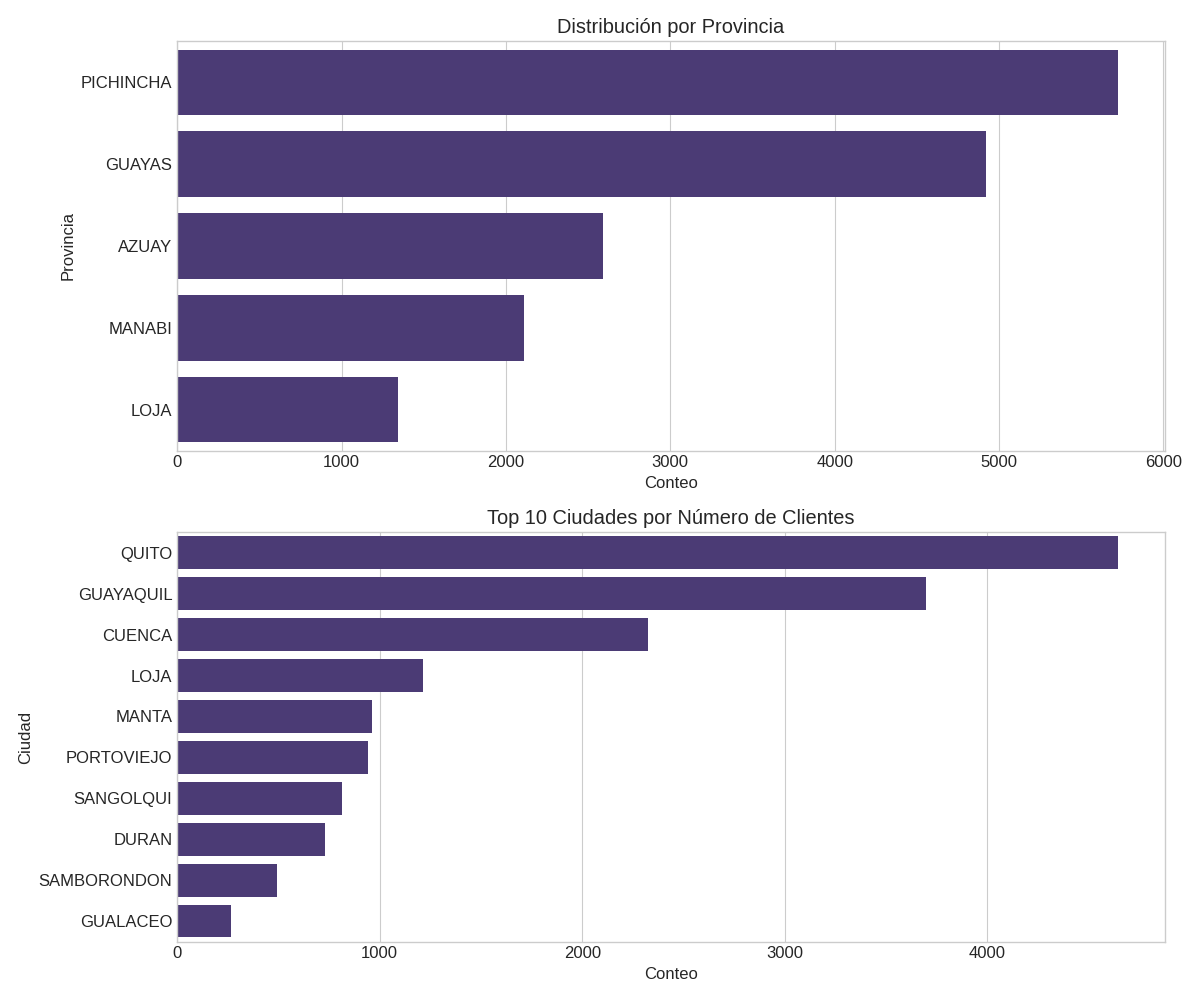

In [19]:
# 3.3 Variables geográficas
plt.figure(figsize=(12, 10))

# Distribución por provincia
plt.subplot(211)
sns.countplot(y='PROV_DOM_CAL_DAT', data=df, order=df['PROV_DOM_CAL_DAT'].value_counts().index)
plt.title('Distribución por Provincia')
plt.xlabel('Conteo')
plt.ylabel('Provincia')

# Ciudades principales
top_ciudades = df['CIUDAD_DOM_CAL_DAT'].value_counts().nlargest(10).index
plt.subplot(212)
sns.countplot(y='CIUDAD_DOM_CAL_DAT', data=df[df['CIUDAD_DOM_CAL_DAT'].isin(top_ciudades)],
              order=df['CIUDAD_DOM_CAL_DAT'].value_counts().nlargest(10).index)
plt.title('Top 10 Ciudades por Número de Clientes')
plt.xlabel('Conteo')
plt.ylabel('Ciudad')

plt.tight_layout()
plt.savefig('geograficos.png')
plt.close()
from IPython.display import Image
display(Image('geograficos.png'))

#**Análisis de variables geográficas**

 **1. Distribución por provincia:**

* **Interpretación:** Este gráfico de barras muestra la distribución de clientes a través de las diferentes provincias.  La provincia de Pichincha tiene el mayor número de clientes, seguida de Guayas.  Las demás provincias (Azuay, Manabí y Loja) muestran una cantidad menor de clientes, reflejando las probabilidades definidas durante la simulación de los datos.  Las barras están ordenadas de mayor a menor frecuencia para facilitar la comparación. El gráfico proporciona una idea de la concentración geográfica de clientes.

**2. Top 10 ciudades por número de clientes:**

* **Interpretación:**  Este gráfico de barras muestra las 10 ciudades con mayor concentración de clientes. Quito (en Pichincha) es la ciudad con más clientes, seguida de Guayaquil (en Guayas). Este resultado es consistente con la distribución de clientes por provincia, ya que Quito y Guayaquil son las ciudades principales de las dos provincias con mayor número de clientes. Las demás ciudades en el top 10 siguen un patrón similar, reflejando la distribución de población simulada dentro de las provincias.  El gráfico proporciona una imagen más granular de la distribución geográfica, mostrando las ciudades con mayor densidad de clientes.

**Resultados generales:**

La distribución geográfica de clientes se concentra en las dos provincias de Pichincha y Guayas, siendo Quito y Guayaquil las ciudades con mayor número de clientes. El análisis muestra una distribución esperada basada en la configuración de la simulación, donde se definieron probabilidades para las provincias y, consecuentemente, para las ciudades dentro de cada provincia.  Estas visualizaciones permiten entender la distribución espacial de los clientes y podrían ser relevantes para estrategias de marketing focalizadas o la planificación de recursos.  Si se trabaja con datos reales, este análisis proporcionaría información real sobre la presencia geográfica de clientes.


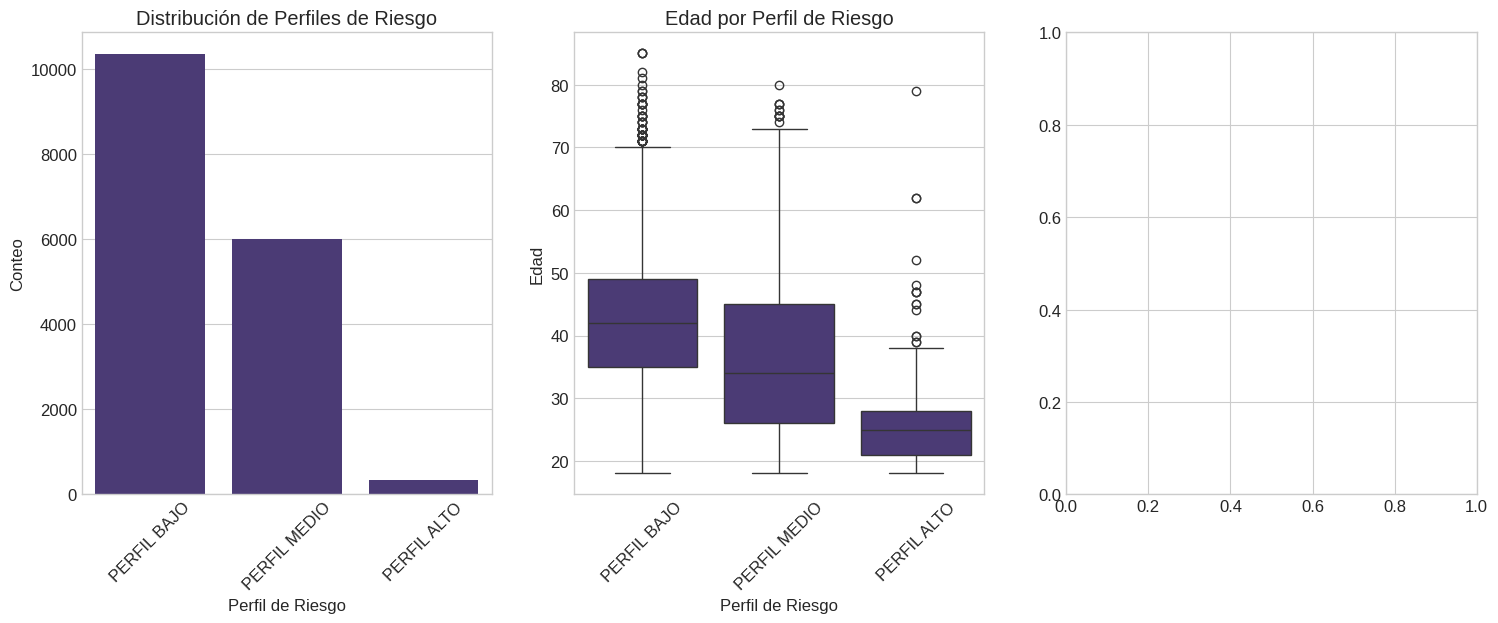

In [20]:
# 3.4 Análisis de perfil de riesgo
plt.figure(figsize=(18, 6))

# Distribución de perfiles de riesgo
plt.subplot(131)
sns.countplot(x='PERFILRIESGOENDEUDAMIENTO', data=df)
plt.title('Distribución de Perfiles de Riesgo')
plt.xlabel('Perfil de Riesgo')
plt.ylabel('Conteo')
plt.xticks(rotation=45)

# Relación entre edad y perfil de riesgo
plt.subplot(132)
sns.boxplot(x='PERFILRIESGOENDEUDAMIENTO', y='EDAD', data=df)
plt.title('Edad por Perfil de Riesgo')
plt.xlabel('Perfil de Riesgo')
plt.ylabel('Edad')
plt.xticks(rotation=45)

# Relación entre estado civil y perfil de riesgo
plt.subplot(133)
df_crosstab = pd.crosstab(df['estado_civil'], df['PERFILRIESGOENDEUDAMIENTO'], normalize='index')
df_crosstab.plot(kind='bar', stacked=True)
plt.title('Perfil de Riesgo por Estado Civil')
plt.xlabel('Estado Civil')
plt.ylabel('Proporción')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('perfiles_riesgo.png')
plt.close()


# Análisis de perfil de riesgo (Interpretación)

**1. Distribución de perfiles de riesgo:**

 * Interpretación: Este gráfico de barras muestra la cantidad de individuos en cada categoría de perfil de riesgo ('PERFIL BAJO', 'PERFIL MEDIO', 'PERFIL ALTO').  La altura de cada barra representa el número de clientes en ese perfil.  Este gráfico da una idea general de la distribución de riesgo en la muestra de datos. Se puede observar si la mayoría de los clientes se encuentran en un perfil bajo, medio o alto de riesgo.  En datos simulados, la distribución puede no reflejar la realidad.


 **2. Relación entre edad y perfil de riesgo:**
 * Interpretación: Este gráfico de caja (boxplot) muestra la distribución de edades para cada perfil de riesgo.  La caja representa el rango intercuartílico (IQR), que contiene el 50% de los datos. La línea dentro de la caja es la mediana. Las líneas que se extienden desde la caja son los bigotes, que muestran el rango de datos dentro de 1.5 veces el IQR. Los puntos fuera de los bigotes son valores atípicos. Al comparar las cajas para cada perfil, podemos ver si hay diferencias significativas en la distribución de edades entre los perfiles de riesgo.  Por ejemplo, si el perfil de 'PERFIL ALTO' tiende a tener una mediana de edad mayor o menor que los otros perfiles, o si tiene más dispersión.


**3. Relación entre estado civil y perfil de riesgo:**
 * Interpretación: Este gráfico de barras apiladas muestra la proporción de cada perfil de riesgo dentro de cada categoría de estado civil.  Cada barra representa un estado civil, y se divide en segmentos que representan las proporciones de los diferentes perfiles de riesgo.  Por ejemplo, en la categoría 'CASADO', se ve la proporción de clientes 'PERFIL BAJO', 'PERFIL MEDIO' y 'PERFIL ALTO'.  Este gráfico ayuda a identificar si hay alguna correlación entre el estado civil y el perfil de riesgo de endeudamiento.  Se pueden observar patrones: si los solteros tienen una mayor proporción de perfil alto, o si los casados tienen una mayor proporción de perfil bajo, etc.

 Resultados generales:
# El análisis conjunto de los gráficos proporciona información sobre el perfil de riesgo en relación con las características demográficas como la edad y el estado civil.  En conjunto, estos gráficos ayudan a comprender cómo el perfil de riesgo se relaciona con otras variables demográficas en el conjunto de datos simulado.  Si se trabajara con un dataset real, estos gráficos serían muy valiosos para la gestión de riesgos, segmentación de clientes y desarrollo de estrategias de negocio.  En este caso simulado, se puede modificar las proporciones para observar los cambios en el comportamiento y ver cómo afectan las distintas variables.


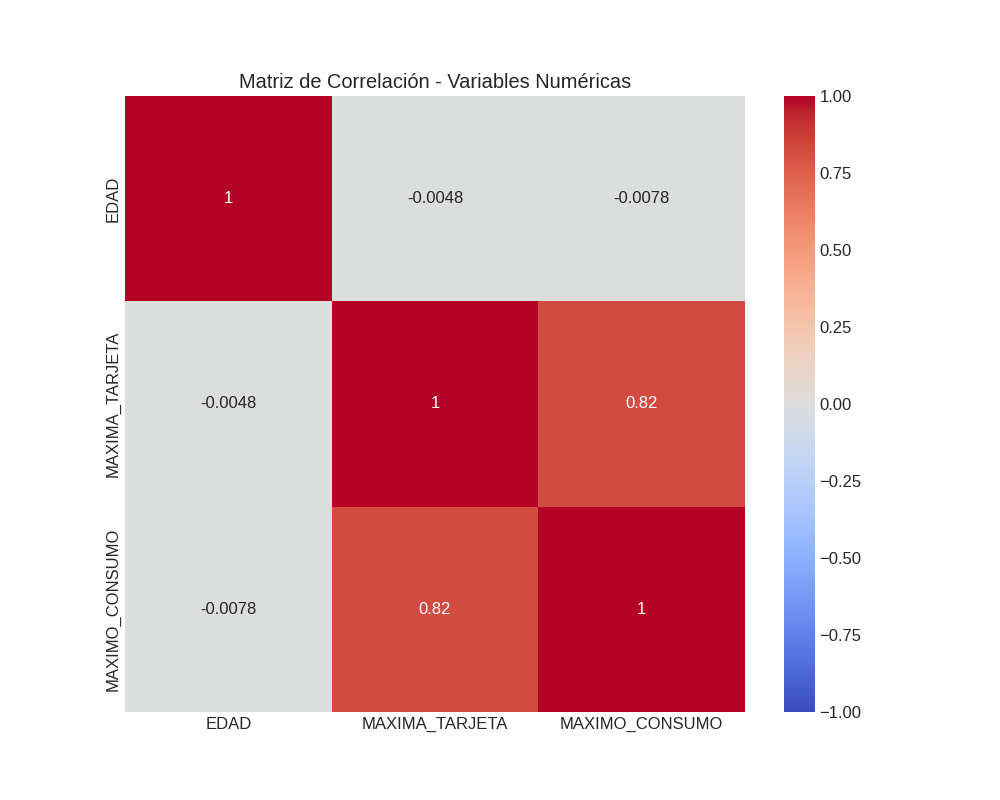

In [21]:
# 4. Análisis de correlaciones entre variables numéricas
plt.figure(figsize=(10, 8))
numeric_df = df[['EDAD', 'MAXIMA_TARJETA', 'MAXIMO_CONSUMO']]
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación - Variables Numéricas')
plt.savefig('correlacion.png')
plt.close()
from IPython.display import Image
display(Image('correlacion.png'))

# Análisis de correlaciones entre variables numéricas (Interpretación)

Interpretación:
La matriz de correlación visualiza las relaciones lineales entre las variables numéricas 'EDAD', 'MAXIMA_TARJETA' y 'MAXIMO_CONSUMO'.  Los valores en la matriz varían de -1 a 1.
 * Un valor cercano a 1 indica una correlación positiva fuerte: a medida que una variable aumenta, la otra también tiende a aumentar.
 * Un valor cercano a -1 indica una correlación negativa fuerte: a medida que una variable aumenta, la otra tiende a disminuir.
 * Un valor cercano a 0 indica una correlación débil o inexistente.

# Resultados generales:
La matriz de correlación muestra la intensidad y dirección de las relaciones lineales entre las variables numéricas del conjunto de datos.  
En este caso simulado, las correlaciones observadas pueden o no reflejar correlaciones reales en datos del mundo real.  Por ejemplo, es posible que una correlación positiva entre 'MAXIMA_TARJETA' y 'MAXIMO_CONSUMO' sea esperada (generalmente, a un mayor límite de tarjeta de crédito, corresponde un mayor gasto), pero su magnitud puede variar.  La correlación entre 'EDAD' y las demás variables podría indicar una tendencia en el límite de la tarjeta o en el consumo máximo según la edad.  La interpretación de estas correlaciones debe hacerse teniendo en cuenta el contexto de los datos.

# Sugerencias para análisis adicionales:
  * Si la correlación observada es estadísticamente significativa, se puede profundizar en la relación entre las variables.
  * Si hay variables con correlaciones altas (mayor a 0.7 o menor a -0.7), se podría considerar la posibilidad de eliminar una de ellas para evitar la multicolinealidad en modelos predictivos.
  * Es importante analizar visualmente las relaciones entre las variables mediante gráficos de dispersión para confirmar las correlaciones y detectar posibles relaciones no lineales.
  * Es importante considerar si la correlación detectada es causal o simplemente una asociación.


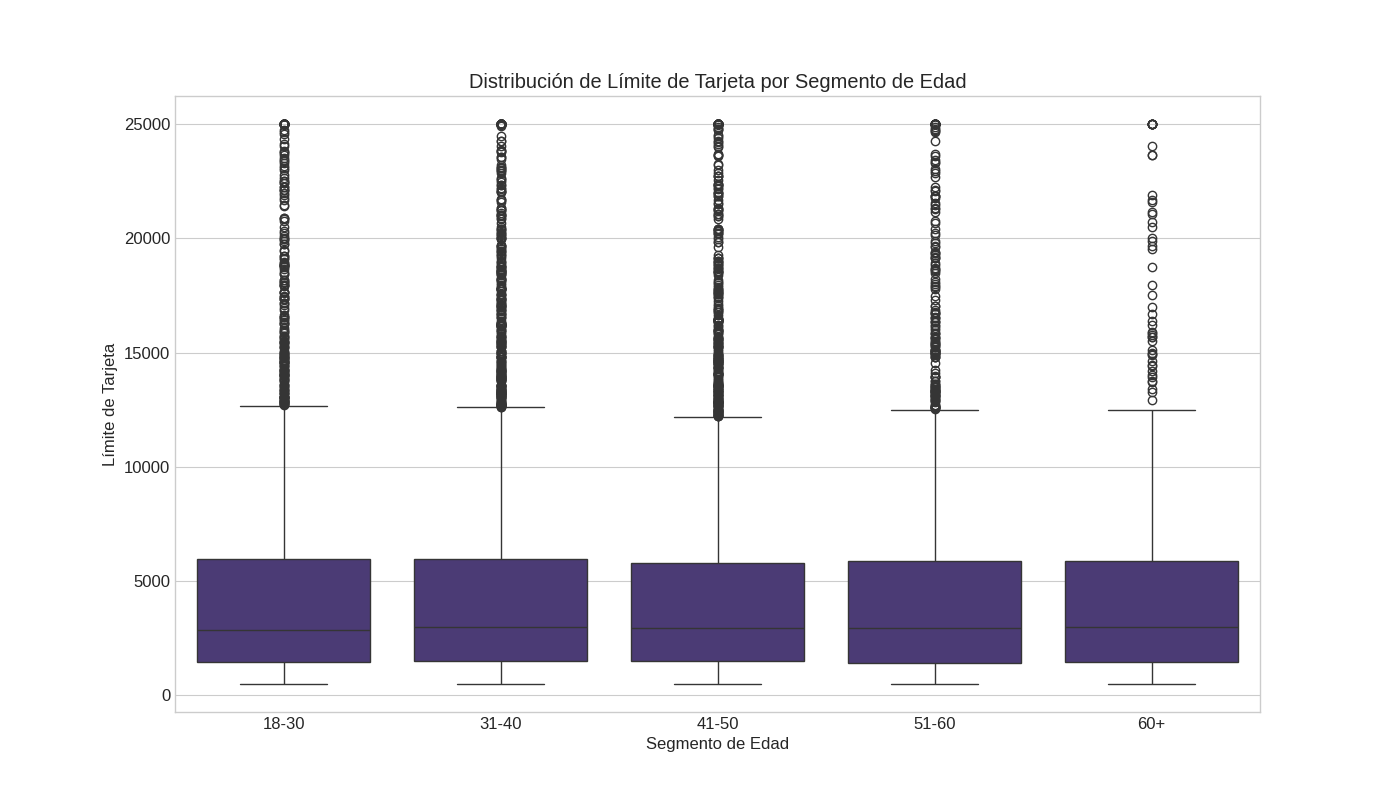

In [22]:
# 5. Análisis por segmento de edad
bins = [18, 30, 40, 50, 60, 100]
labels = ['18-30', '31-40', '41-50', '51-60', '60+']
df['segmento_edad'] = pd.cut(df['EDAD'], bins=bins, labels=labels)

plt.figure(figsize=(14, 8))
# Relación entre segmento de edad y límite de tarjeta
sns.boxplot(x='segmento_edad', y='MAXIMA_TARJETA', data=df)
plt.title('Distribución de Límite de Tarjeta por Segmento de Edad')
plt.xlabel('Segmento de Edad')
plt.ylabel('Límite de Tarjeta')
plt.savefig('limite_por_edad.png')
plt.close()
from IPython.display import Image
display(Image('limite_por_edad.png'))

# Análisis por segmento de edad (Interpretación)

 Interpretación: Este gráfico de caja (boxplot) muestra la distribución del límite de la tarjeta de crédito para cada segmento de edad.  Los segmentos de edad se definen por rangos de edad (18-30, 31-40, 41-50, 51-60, 60+).  La caja representa el rango intercuartílico (IQR), la línea dentro de la caja es la mediana, las líneas que se extienden son los bigotes, y los puntos fuera de los bigotes son valores atípicos.  Al comparar las cajas entre los segmentos, podemos ver si hay diferencias significativas en la distribución del límite de la tarjeta entre los grupos de edad.  Por ejemplo, se puede observar si el grupo de edad de 41-50 años tiende a tener límites de tarjeta más altos que el grupo de 18-30 años, o si hay mayor dispersión en los límites de tarjeta dentro de un grupo de edad en particular.

# Resultados generales:
El boxplot proporciona una visión general de la relación entre el límite de la tarjeta de crédito y la edad.  Al observar la mediana y el rango intercuartílico de cada segmento de edad, podemos entender cómo el límite de la tarjeta varía con la edad. La presencia de valores atípicos puede indicar clientes con límites de tarjeta significativamente más altos o más bajos dentro de un grupo de edad específico.  Se pueden observar patrones como si los límites de tarjeta tienden a aumentar con la edad, o si hay grupos de edad con mayor variabilidad en los límites.  Este análisis es valioso para entender el comportamiento del cliente en relación a la edad y se puede utilizar para adaptar estrategias específicas para cada segmento de edad.  En datos reales, sería útil para desarrollar ofertas de productos más atractivas para cada grupo de edad.  En este dataset simulado, es crucial entender cómo la configuración de la simulación afecta a la distribución de los límites de tarjeta por segmento de edad, por ejemplo, las probabilidades asignadas a cada rango de edad o si hay patrones predefinidos en el límite.


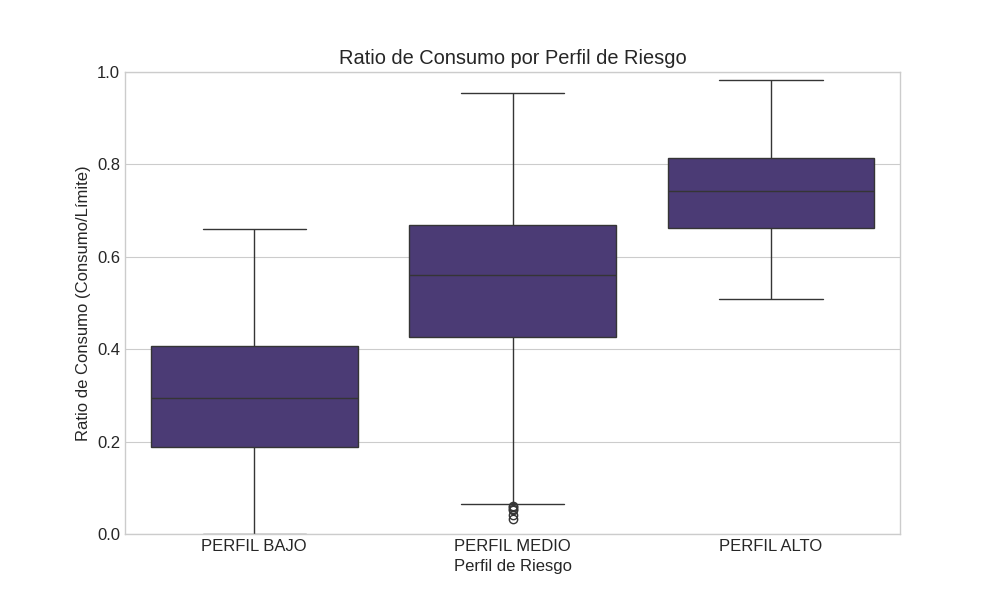

In [23]:
# 6. Ratio de consumo por perfil
df['ratio_consumo'] = df['MAXIMO_CONSUMO'] / df['MAXIMA_TARJETA']

plt.figure(figsize=(10, 6))
sns.boxplot(x='PERFILRIESGOENDEUDAMIENTO', y='ratio_consumo', data=df)
plt.title('Ratio de Consumo por Perfil de Riesgo')
plt.xlabel('Perfil de Riesgo')
plt.ylabel('Ratio de Consumo (Consumo/Límite)')
plt.ylim(0, 1)
plt.savefig('ratio_consumo.png')
plt.close()
from IPython.display import Image
display(Image('ratio_consumo.png'))

# Análisis del Ratio de Consumo por Perfil de Riesgo (Interpretación)

Interpretación:Este gráfico de caja muestra la distribución del ratio de consumo (Consumo Máximo / Límite Máximo de Tarjeta) para cada perfil de riesgo de endeudamiento.  El ratio de consumo proporciona una medida de la proporción del límite de la tarjeta que utiliza cada cliente.  Un ratio cercano a 1 indica que el cliente utiliza la totalidad de su límite disponible, mientras que un ratio cercano a 0 indica un bajo uso del límite.

# Observaciones Clave:
 * Comparación entre Perfiles: Se deben comparar las medianas y los rangos intercuartílicos de cada perfil.  Un perfil con una mediana más alta indica que, en promedio, los clientes de ese perfil tienden a utilizar una mayor proporción de su límite de crédito.  La dispersión de los datos (representada por el rango intercuartílico y los bigotes) muestra la variabilidad en el uso del crédito dentro de cada perfil.
 * Valores Atípicos: Los puntos fuera de los bigotes representan valores atípicos, que son clientes con ratios de consumo significativamente más altos o más bajos que el resto del perfil.  Es importante analizar estos valores atípicos para entender las razones detrás de su comportamiento de consumo.
 * Límite del Eje Y: El eje y está limitado a 0 y 1.  Esto es importante porque el ratio de consumo no puede ser mayor que 1 (a menos que haya errores en los datos).  Si hay valores por encima de 1, esto indicaría que el consumo máximo es superior al límite de la tarjeta, lo cual debe ser investigado.

# Resultados Generales:
 El análisis del ratio de consumo proporciona información adicional sobre el comportamiento de los clientes en relación con su perfil de riesgo.  Permite identificar perfiles que tienden a utilizar una mayor proporción de su límite de crédito, lo que podría ser un indicador de riesgo de endeudamiento.  Esta información es crucial para la gestión de riesgos, la segmentación de clientes y la toma de decisiones estratégicas, como la asignación de límites de crédito o la oferta de productos financieros específicos.

# Consideraciones Adicionales para el Dataset:
 Es crucial revisar cómo la simulación ha generado estos ratios.  Es necesario saber si existe una correlación predefinida entre el perfil de riesgo y el ratio de consumo, o si se ha establecido un modelo estocástico para generar estos valores.  Entender el mecanismo ayuda a interpretar los resultados del análisis.

# Análisis de Segmentos con Mayor Riesgo:

# Se sugiere profundizar en el análisis de los segmentos con mayor riesgo.  Esto podría incluir:

 * Análisis Bivariado: Examinar la relación entre el ratio de consumo y otras variables importantes para cada perfil de riesgo (e.g., ingreso, edad, estado civil, etc.)
 * Variables Adicionales: Explorar si existen variables no consideradas que puedan estar correlacionadas con el ratio de consumo y el perfil de riesgo.

# Conclusiones:

 En resumen, la interpretación de este gráfico, junto con el análisis de otras variables, proporciona información valiosa para entender la relación entre el perfil de riesgo, el comportamiento de consumo y la gestión de riesgos crediticios.  En un escenario con datos reales, este tipo de análisis proporciona información crucial para la toma de decisiones.


cluster
 0    16593
-1       82
 2        5
 1        3
Name: count, dtype: int64


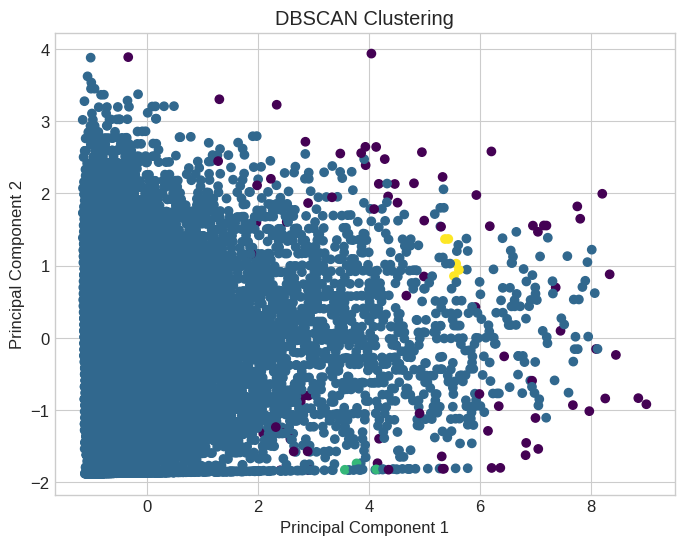

In [24]:
from sklearn.cluster import DBSCAN
# Suponiendo que 'df' es tu DataFrame y 'X' contiene las características numéricas para el clustering
# Por ejemplo:
X = df[['EDAD', 'MAXIMA_TARJETA', 'MAXIMO_CONSUMO']]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajustar eps y min_samples según tus datos
clusters = dbscan.fit_predict(X_scaled)

# Agregar los clusters al DataFrame
df['cluster'] = clusters

# Analizar los resultados
print(df['cluster'].value_counts())
# Visualizar los clusters (ejemplo con las primeras dos componentes principales)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

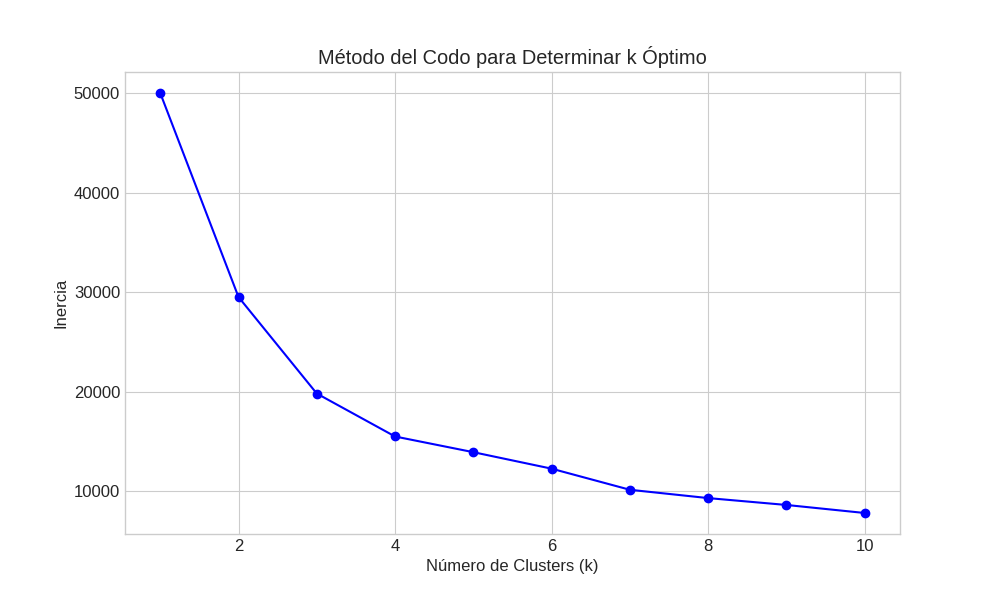

In [25]:
# 7. Exploración de patrones mediante clustering preliminar
# Seleccionamos las variables más relevantes para el clustering
X = df[['EDAD', 'MAXIMA_TARJETA', 'MAXIMO_CONSUMO']]

# Preprocesamiento: escalado de variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7.1 Determinación del número óptimo de clusters con el método del codo
inertias = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.title('Método del Codo para Determinar k Óptimo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.savefig('metodo_codo.png')
plt.close()
from IPython.display import Image
display(Image('metodo_codo.png'))

# Análisis del Método del Codo (Interpretación)

# Interpretación:El método del codo se utiliza para determinar el número óptimo de clusters (k) para el algoritmo KMeans. El gráfico muestra la inercia (suma de las distancias cuadradas de las muestras al centroide de su cluster más cercano) en función del número de clusters.  El objetivo es encontrar el valor de "k" donde la disminución de la inercia comienza a disminuir lentamente, formando un "codo" en la gráfica.

# Observaciones Clave:
 * Disminución de la Inercia: A medida que "k" aumenta, la inercia disminuye.  Esto es porque con más clusters, cada punto de datos está más cerca de su centroide.
 * El "Codo": Se busca el punto en la gráfica donde la disminución de la inercia se vuelve menos pronunciada, formando el "codo".  Este punto representa un equilibrio entre la complejidad del modelo (mayor "k" = mayor complejidad) y la reducción de la inercia (mejor ajuste a los datos).
 * Interpretación del gráfico: Se debe observar el gráfico para encontrar el punto donde el "codo" es más evidente.  En este caso se observa una clara disminución de la inercia hasta k=3,  después la disminución es mucho menor.  Esto sugeriría que k=3 es un buen número de clusters. Sin embargo, es importante comparar con otras métricas para confirmar.

# Resultados Generales:
 El método del codo proporciona una guía para seleccionar el valor de "k".  Es importante recordar que este método es solo una heurística y puede no ser siempre concluyente. Se recomienda combinarlo con otras métricas, como el índice de silueta, para obtener una mejor idea del número óptimo de clusters.  En el caso real se debe observar cual es el "codo" mas apropiado.

# Consideraciones Adicionales:
 * El valor de "k" óptimo puede variar dependiendo del conjunto de datos.
 * Se pueden explorar valores de "k" alrededor del "codo" para obtener resultados satisfactorios.
 * Es importante visualizar los clusters resultantes para verificar su validez y significado práctico.

# Recomendaciones Adicionales:

# * Calcular el índice de silueta para diferentes valores de "k", incluyendo el indicado por el método del codo.  El índice de silueta cuantifica qué tan similares son los puntos de datos dentro de su cluster en comparación con puntos de otros clusters.  Se busca el valor de "k" que maximice el índice de silueta.

 * Visualizar los clusters resultantes para diferentes valores de "k" en un espacio bidimensional (usando PCA o t-SNE). Esto proporcionará una mejor comprensión de la estructura de los datos y ayudara a identificar el número óptimo de clusters.


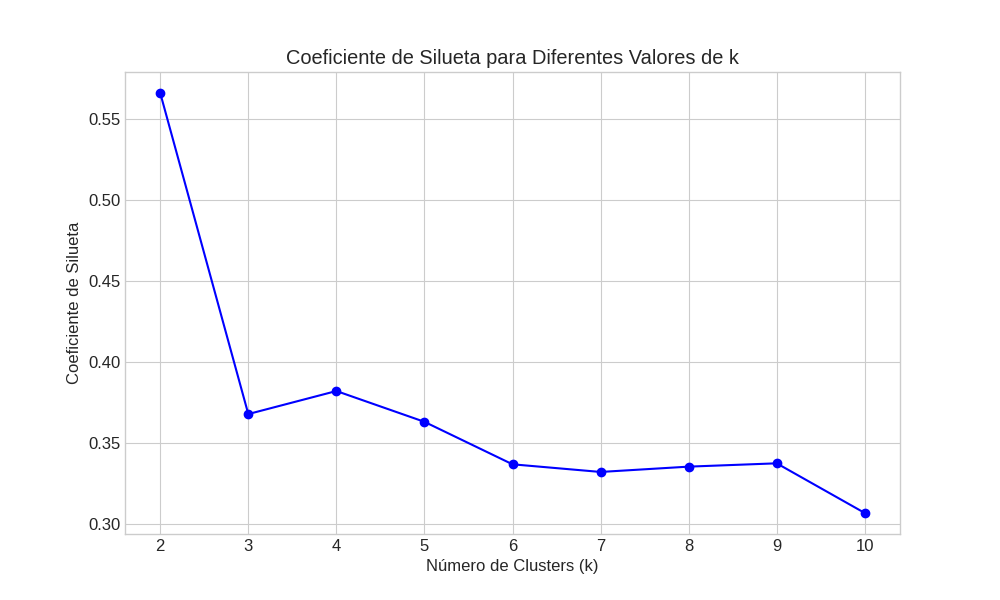

In [26]:
# 7.2 Evaluación con el coeficiente de silueta
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.title('Coeficiente de Silueta para Diferentes Valores de k')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta')
plt.grid(True)
plt.savefig('silueta.png')
plt.close()
from IPython.display import Image
display(Image('silueta.png'))

# Análisis del Coeficiente de Silueta (Interpretación)

Interpretación: El coeficiente de silueta se utiliza para evaluar la calidad de los clusters generados por el algoritmo KMeans.  El coeficiente varía de -1 a 1.

# Observaciones Clave:
 * Valores Cercanos a 1: Indican que los puntos de datos están bien asignados a su cluster y están lejos de otros clusters.
 * Valores Cercanos a 0: Indican que los puntos de datos están cerca del límite entre dos clusters.
 * Valores Cercanos a -1: Indican que los puntos de datos pueden estar asignados incorrectamente a su cluster y deberían pertenecer a un cluster adyacente.
 * Interpretación del gráfico: Se debe buscar el valor de "k" que maximiza el coeficiente de silueta.  Este valor de "k" indica el número óptimo de clusters.  En este caso, se debe observar cual es el "pico" mas alto.  Esto podría indicar el mejor valor de k. Sin embargo, se debe comparar con el método del codo.
 * Comparación con el método del codo:  La combinación de ambos métodos proporciona una mejor estimación de k.

# Resultados Generales:
El coeficiente de silueta proporciona una medida cuantitativa de la calidad de los clusters.  Un valor de silueta alto indica que los clusters son compactos y bien separados.  Como se observo, el valor óptimo de k podría no coincidir con el del método del codo, por lo cual se debe comparar ambos.  Combinando ambos métodos se puede tener una mejor elección de k.

# Consideraciones Adicionales:
 * El coeficiente de silueta puede ser sensible a la forma de los clusters.
 * Es importante considerar el contexto del problema al interpretar los resultados del coeficiente de silueta.

# Análisis de Componentes Principales (PCA):

 Este análisis de componentes principales (PCA) busca reducir la dimensionalidad de los datos sin una pérdida significativa de información, proyectando los datos a un espacio de menor dimensión.
 * Análisis gráfico: Es importante visualizar los clusters en el espacio de componentes principales para tener una comprensión visual de cómo se separan los grupos en este nuevo espacio.
 * Interpretación de las componentes:  Se debería analizar que variables contribuyen a cada componente principal.  Esto ayudará a entender qué variables tienen mayor peso en la formación de los clusters.

# Dendograma (Análisis Jerárquico de Clusters):

# Un dendograma representa los clusters jerárquicamente.
 * Identificar las líneas de corte: Se buscan puntos de corte en el dendograma donde haya la mayor distancia entre clusters.  Esto ayuda a determinar un buen número de clusters.
 * Interpretación de los clusters:  Cada punto de datos se agrupa con otros puntos de datos similares. El dendograma visualiza cómo se forman los clusters jerárquicamente.  Cada cluster representa una agrupación de clientes que comparten características similares.  Analizar el dendograma en conjunto con los resultados del método del codo y el coeficiente de silueta, junto con otras métricas, como la visualización de los clusters, es útil para la selección del número óptimo de cluster.

# Conclusiones:
 En resumen, se deben considerar los resultados de los tres métodos (método del codo, coeficiente de silueta, y dendograma) conjuntamente con la visualización de los clusters resultantes en el espacio PCA.  La interpretación exhaustiva de estos métodos, junto con otras métricas, es la clave para un análisis robusto del clustering.


In [37]:
# 7.3 Aplicación preliminar de K-means con k=4 (valor asumido óptimo)
from sklearn.cluster import KMeans # Make sure KMeans is imported
from sklearn.preprocessing import StandardScaler

# Select features for clustering
X = df[['EDAD', 'MAXIMA_TARJETA', 'MAXIMO_CONSUMO']]

# Preprocessing: scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Define X_scaled here before using it

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

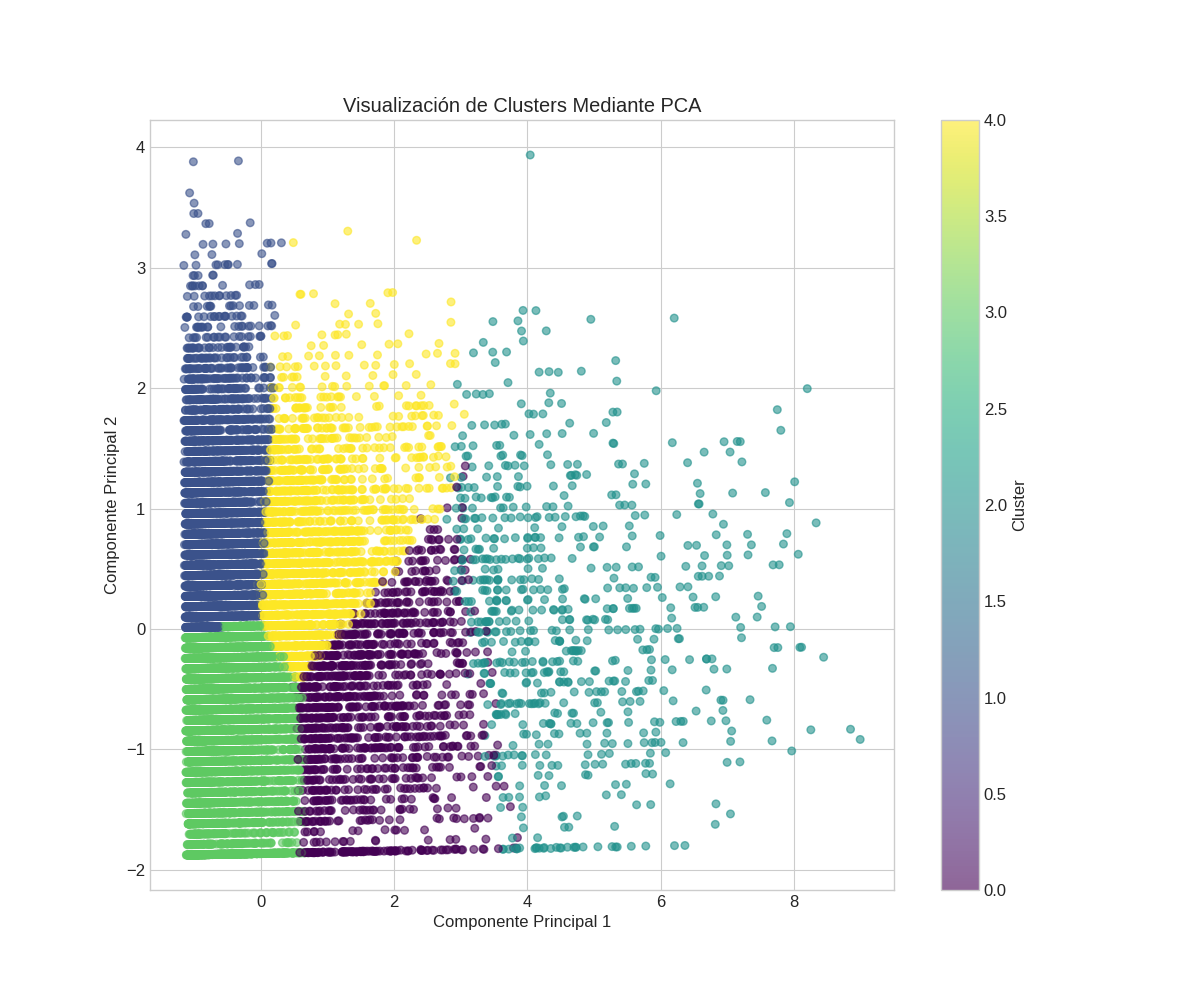

In [28]:
# Visualización de los clusters en 2D usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6, s=30)
plt.colorbar(scatter, label='Cluster')
plt.title('Visualización de Clusters Mediante PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.savefig('clusters_pca.png')
plt.close()
from IPython.display import Image
display(Image('clusters_pca.png'))

# Análisis de la Visualización de Clusters mediante PCA (Interpretación)

Interpretación:Este gráfico muestra la distribución de los clientes en un espacio bidimensional reducido mediante PCA (Análisis de Componentes Principales).  Cada punto representa un cliente, y el color del punto indica a qué cluster pertenece según el algoritmo K-Means.  La visualización en 2D nos permite observar la separación entre los clusters.

# Observaciones Clave:
 * Separación de Clusters: Se debe observar si los clusters están bien separados en el espacio 2D. Una buena separación indica que el algoritmo ha logrado agrupar clientes con características similares.  Si los clusters se superponen significativamente, esto sugiere que la separación entre los grupos no es clara, y el número de clusters podría no ser el óptimo, o se necesitan más variables para una mejor segmentación.
 * Distribución de los Puntos: La forma y la dispersión de los puntos dentro de cada cluster también son relevantes. Un cluster con una forma esférica y una baja dispersión indica homogeneidad dentro del grupo. Clusters con formas irregulares o alta dispersión sugieren heterogeneidad dentro del cluster, lo que puede indicar que el número de clusters o las variables utilizadas para el clustering no son las más adecuadas.
 * Interpretación de los Componentes Principales:  Se debe recordar que las coordenadas en el gráfico representan las dos primeras componentes principales obtenidas mediante PCA.  Cada componente principal es una combinación lineal de las variables originales ('EDAD', 'MAXIMA_TARJETA', 'MAXIMO_CONSUMO'). Es importante entender qué variables originales contribuyen más a cada componente principal para interpretar la separación de los clusters.  Por ejemplo, la componente principal 1 podría estar fuertemente relacionada con el 'MAXIMO_CONSUMO', mientras que la componente principal 2 podría estar más relacionada con la 'EDAD'. Esto permitiría inferir que los clusters se separan principalmente por su nivel de consumo o por edad.

# Resultados Generales:
 La visualización PCA proporciona una representación visual de los clusters identificados por el algoritmo K-Means. Permite evaluar la calidad de la agrupación y proporciona pistas sobre las características que diferencian a los clusters.  En este caso, observamos una separación entre los clusters aunque puede que haya cierta superposicion. La interpretación de la separación de estos clusters requiere considerar la combinación de variables que componen los dos ejes principales.

 * Profundizar en las características de cada cluster: Una vez identificados los clusters visualmente, se debe realizar un análisis descriptivo para entender las características que definen a cada uno. Por ejemplo, el rango de edad promedio, el límite de tarjeta promedio, el consumo máximo promedio para cada cluster.
 * Comparación con otras variables: Si se dispone de más variables (e.g., ingresos, historial de pagos, etc.), se puede comparar el comportamiento de estas variables en cada cluster para tener una comprensión más completa de las diferencias entre grupos.
 * Validación con datos reales: Si los datos son simulados, se deben contrastar los patrones observados con datasets del mundo real para validar los patrones identificados.

 # Conclusiones:
La visualización PCA ayuda a entender la separación de los clusters generados por K-Means. Sin embargo, para obtener conclusiones más robustas, es necesario realizar un análisis descriptivo y una comparación con otras variables. Es crucial evaluar si la separación de clusters es significativa en el contexto del negocio o del problema específico que se está tratando de resolver.  Con datos simulados, se debe prestar atención a los patrones introducidos artificialmente para obtener interpretaciones correctas.


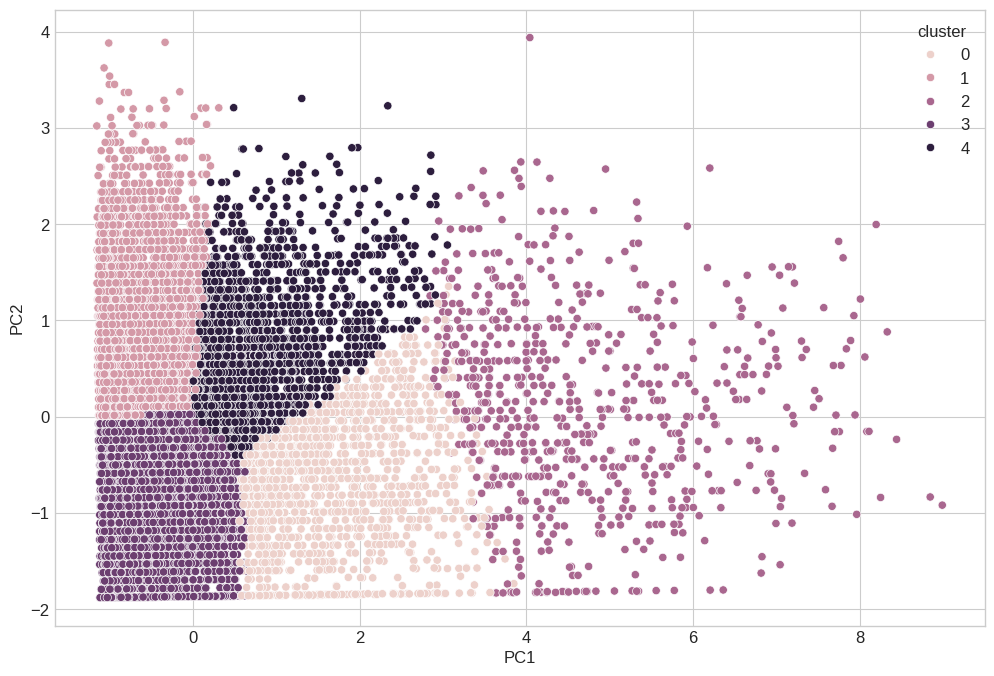

In [29]:
from scipy.spatial import ConvexHull

# Assuming 'pc_transformation' DataFrame is already created and contains 'PC1', 'PC2', and 'Cluster' columns.
# Example:
# pc_transformation = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'Cluster': df['cluster']})
import pandas as pd # Import pandas to use DataFrame

def plot_convex_hull(data_hull, cl_method, colx="PC1", coly="PC2", color=['orange', 'c', 'm', 'g']): #Added more colors
    # Usa colx, coly para el scatterplot
    #cl_method: nombre de la columna de resultados de clustering, se usa para el hue
    # color, lista de colores, tantos como clusteres
    sns.scatterplot(x=data_hull[colx], y=data_hull[coly], hue=data_hull[cl_method])

    unique_clusters = data_hull[cl_method].unique()
    for i, cluster in enumerate(unique_clusters):
        points = np.array(data_hull[[colx, coly]])
        points = points[np.where(data_hull[cl_method] == str(cluster))[0]] # Convert cluster to string for comparison

        if len(points) > 2: # ConvexHull requires at least 3 points
            hull = ConvexHull(points)
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], color[i % len(color)]) # Cycle through colors

# Create pc_transformation DataFrame
pc_transformation = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'cluster': df['cluster']}) # Define pc_transformation

plot_convex_hull(pc_transformation, 'cluster') # Assuming 'cluster' column exists in pc_transformation
plt.show()

In [30]:
# 7. Exploración de patrones mediante clustering preliminar
# Seleccionamos las variables más relevantes para el clustering
X = df[['EDAD', 'MAXIMA_TARJETA', 'MAXIMO_CONSUMO']] # Define X with only numerical features

# Preprocesamiento: escalado de variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)

# Scale the data using StandardScaler if it hasn't been scaled already
# Assuming 'X' contains the features for PCA, as in previous cells
from sklearn.preprocessing import StandardScaler # import StandardScaler
scaler = StandardScaler() # create an instance of StandardScaler
data_scaled = scaler.fit_transform(X) # fit and transform the data

principalComponents = pca.fit_transform(data_scaled)

pc_transformation = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2', 'PC3'])

pc_transformation['Cluster'] = pd.Categorical(kmeans.labels_)

In [31]:
import plotly.express as px

fig = px.scatter_3d(pc_transformation, x='PC1', y='PC2', z='PC3',
              color='Cluster')
fig.show()

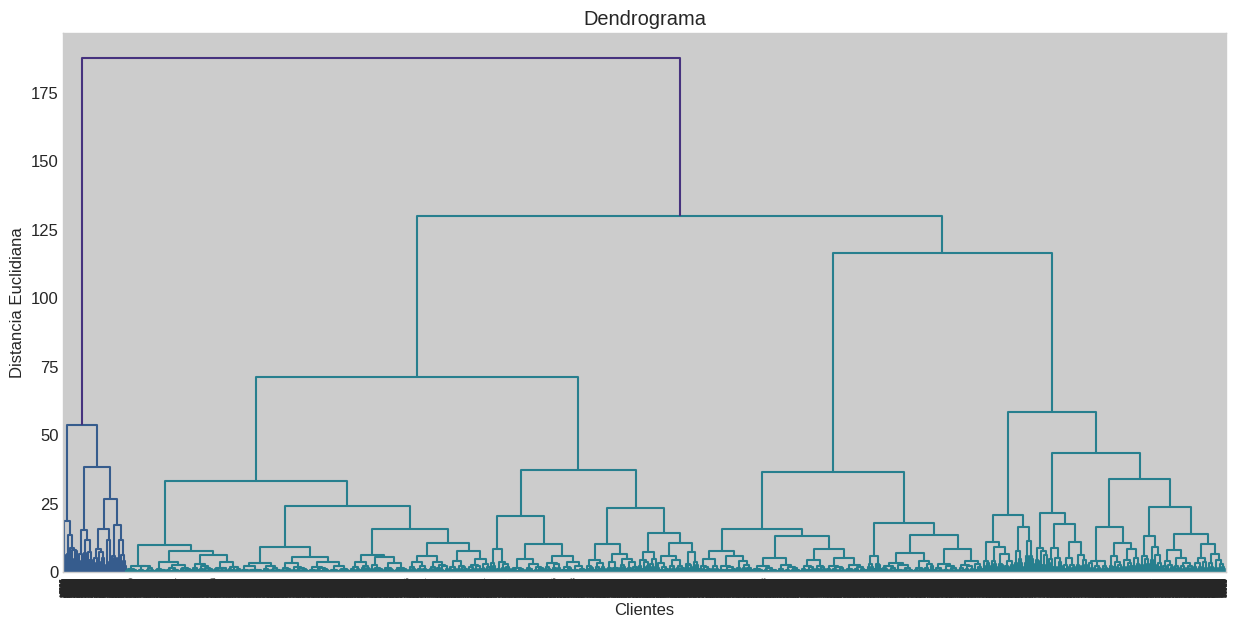

In [32]:
# prompt: generar un Enlace de Ward (Ward's Linkage) utilizar los mismos colores que se utiliza en el grafico pca

import scipy.cluster.hierarchy as sch

# Assuming X_scaled is your scaled data from the previous code
plt.figure(figsize=(15, 7))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward')) # Use ward linkage
plt.title('Dendrograma')
plt.xlabel('Clientes')
plt.ylabel('Distancia Euclidiana')
plt.show()


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from google.colab import drive
from IPython.display import Image
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
import pandas as pd
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
import ipywidgets

# Assuming 'X_scaled' and 'df' are defined as in the previous code
# Example:
# X = df[['EDAD', 'MAXIMA_TARJETA', 'MAXIMO_CONSUMO']]
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Calculate linkage matrix for dendrogram
Z = sch.linkage(X_scaled, method='ward')

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    ddata = sch.dendrogram(*args, **kwargs)
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

d = [10, 7.5, 5.75, 5.325] # Example distances, adjust as needed

@ipywidgets.interact
def plot(Clusters=[2, 3, 4, 5]):
    cluster = AgglomerativeClustering(n_clusters=Clusters, metric='euclidean', linkage='ward')
    labels = cluster.fit_predict(X_scaled)
    print(np.unique(labels, return_counts=True))
    plt.figure(figsize=(12, 8))
    fancy_dendrogram(
        Z,
        truncate_mode='lastp',
        p=12,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True,
        annotate_above=10,
        max_d=d[Clusters-2],
    );
    plt.show()


interactive(children=(Dropdown(description='Clusters', options=(2, 3, 4, 5), value=2), Output()), _dom_classes…

In [55]:
data_cl = pd.DataFrame(index=df.index)

for n_clusters in range(2, 5): # Iterate through 2, 3, and 4 clusters
    cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    labels = cluster.fit_predict(X_scaled)
    data_cl[f'agglomerative_{n_clusters}'] = labels.astype('str')

data_cl["PC1"] = pc_transformation.PC1
data_cl["PC2"] = pc_transformation.PC2
data_cl["PC3"] = pc_transformation.PC3

# Assuming 'Age' column exists in your original DataFrame 'df'
# If not, adjust the code accordingly
data_cl['Age'] = pd.Categorical(df['EDAD'],  # Use 'df['EDAD']' instead of 'data_cl['Age']'
                                   categories=['twenty', 'thirty', 'forty'],
                                   ordered=True)
data_cl

agglomerative_2 agglomerative_3 agglomerative_4       PC1       PC2  \
0                   0               2               0 -1.031192  0.442635   
1                   0               2               0 -0.460723 -0.152471   
2                   0               2               0 -0.937267  0.615803   
3                   0               2               0 -0.992015  1.560551   
4                   0               2               0  0.086563 -0.231867   
...               ...             ...             ...       ...       ...   
16678               1               1               1  5.318651 -0.261130   
16679               0               2               0 -1.053165  0.012578   
16680               0               2               0 -0.900153  0.358587   
16681               0               2               0 -0.924914 -0.243361   
16682               0               0               3 -1.084276 -1.105021   

            PC3  Age  
0      0.118769  NaN  
1     -0.040777  NaN  
2      0.022275  NaN  
3      0.076245  NaN  
4     -0.294885  NaN  
...         ...  ...  
16678 -0.414933  NaN  
16679  0.140782  NaN  
16680 -0.070654  NaN  
16681 -0.065878  NaN  
16682  0.094728  NaN  

[16683 rows x 7 columns]

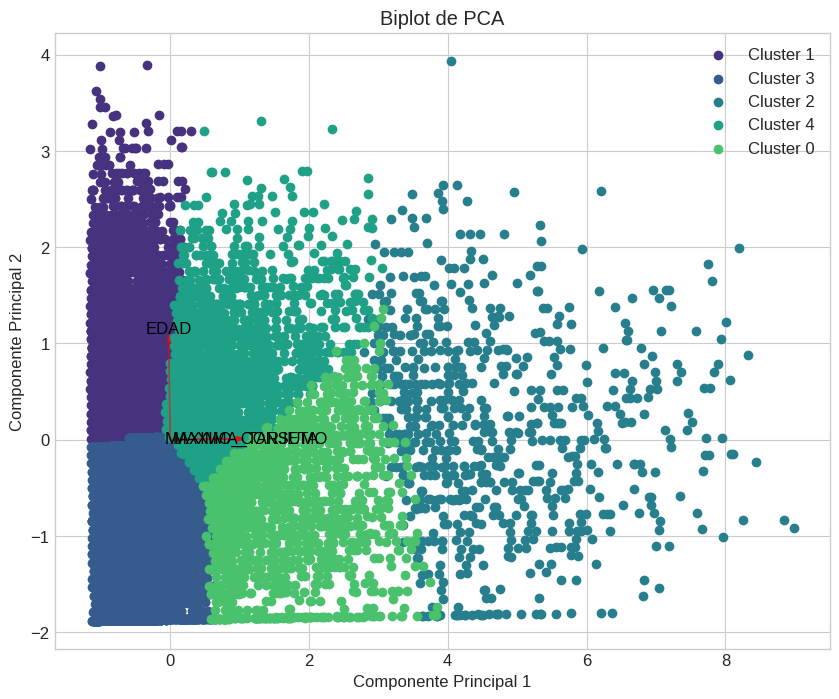

In [58]:
# prompt: generar grafico biplot de pca componentes

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Assuming X_scaled and df['cluster'] are defined from previous code

# Visualización del Biplot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear el DataFrame para el biplot
biplot_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
biplot_df['Cluster'] = df['cluster']

# Obtener las coordenadas de las variables originales en el espacio PCA
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
variables = X.columns  # Nombres de las variables originales

plt.figure(figsize=(10, 8))

# Dibujar los puntos de los datos
for cluster in biplot_df['Cluster'].unique():
    plt.scatter(biplot_df[biplot_df['Cluster'] == cluster]['PC1'],
                biplot_df[biplot_df['Cluster'] == cluster]['PC2'],
                label=f'Cluster {cluster}')

# Dibujar las flechas de las variables
for i, variable in enumerate(variables):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
    plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, variable, color='k', ha='center', va='center')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Biplot de PCA')
plt.legend()
plt.grid(True)
plt.show()


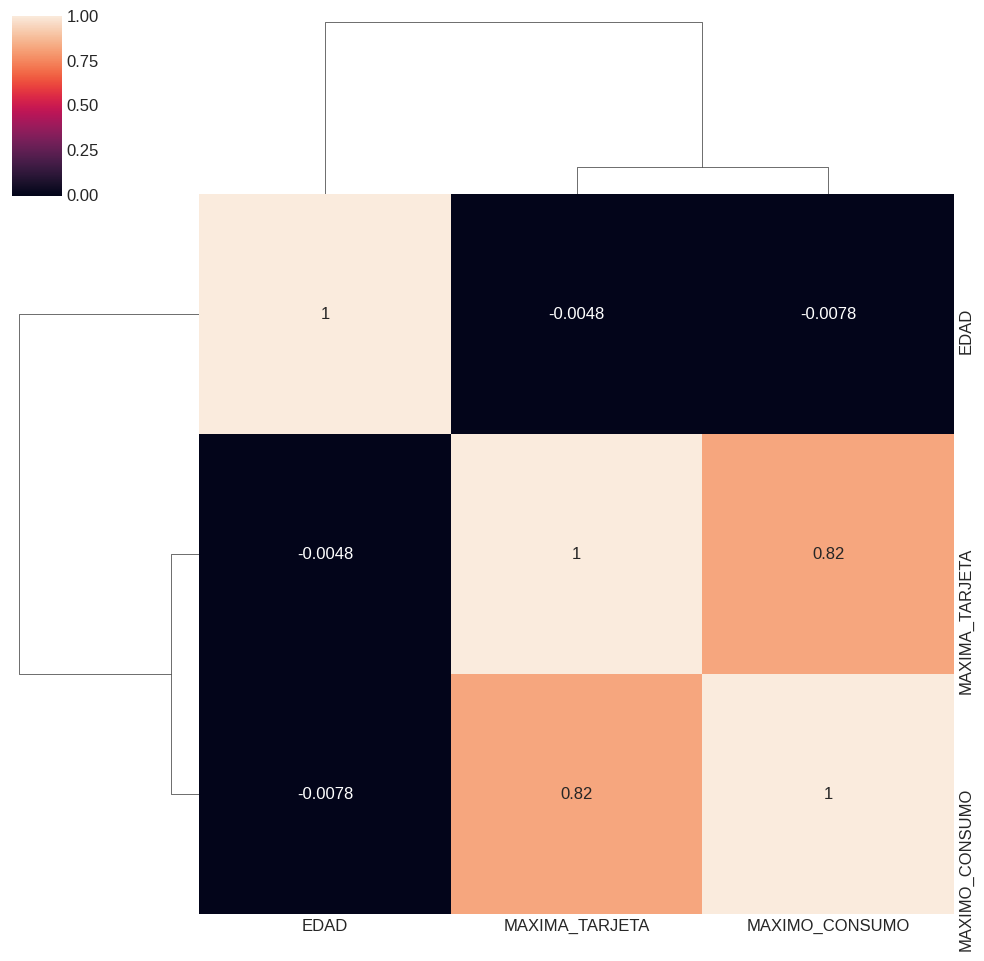

In [59]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with the original data
# Select the features for clustering
X = df[['EDAD', 'MAXIMA_TARJETA', 'MAXIMO_CONSUMO']]

# If you need to one-hot encode categorical features, do it here
# Example:
# categorical_features = ['sexo', 'estado_civil']
# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # handle_unknown='ignore' to avoid errors with unseen values
# encoded_data = pd.DataFrame(encoder.fit_transform(df[categorical_features]))
# encoded_data.columns = encoder.get_feature_names_out(categorical_features)
# encoded_data = pd.concat([df.drop(categorical_features, axis=1), encoded_data], axis=1)

# For numerical features, you can use the original DataFrame or scaled data
encoded_data = X  # or encoded_data = scaler.fit_transform(X) if you scaled the data previously

# Now you can create the clustermap
sns.clustermap(encoded_data.corr(), annot=True)
plt.show()

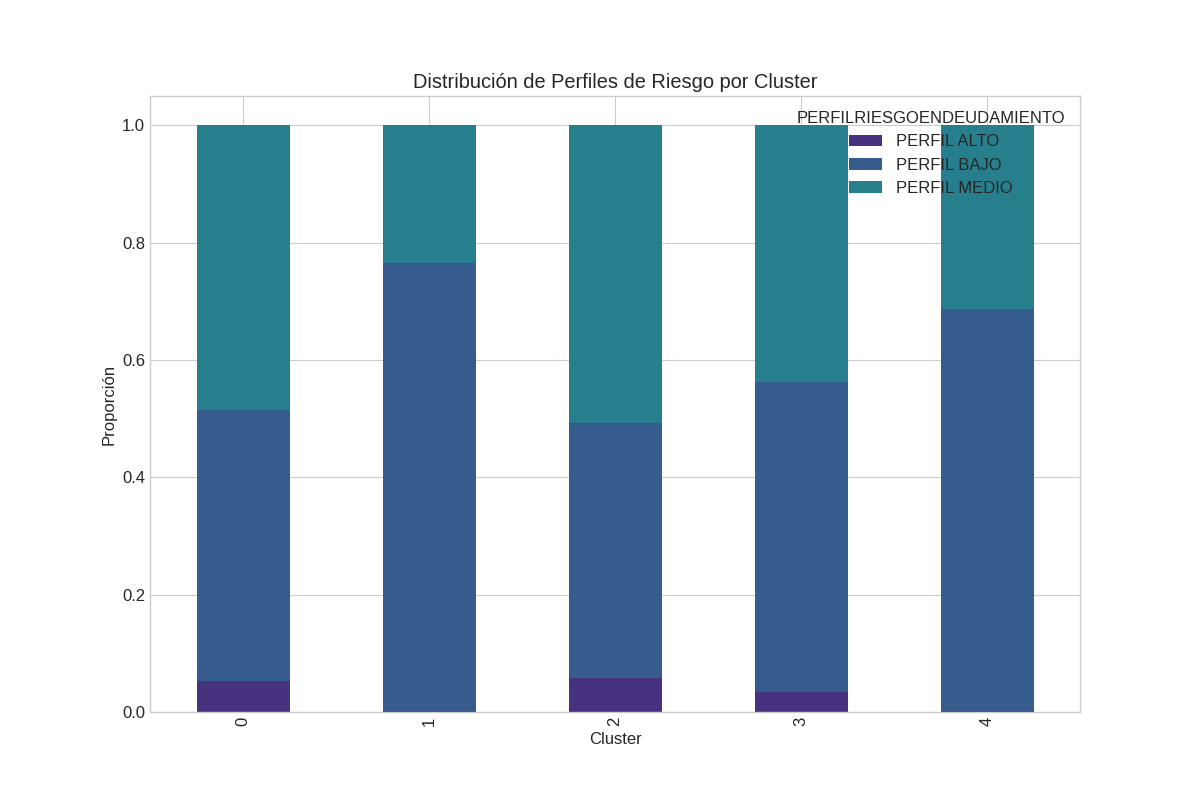

<Figure size 1200x600 with 0 Axes>

In [60]:
# 7.4 Comparación de clusters con perfil de riesgo
plt.figure(figsize=(12, 6))
crosstab = pd.crosstab(df['cluster'], df['PERFILRIESGOENDEUDAMIENTO'], normalize='index')
crosstab.plot(kind='bar', stacked=True)
plt.title('Distribución de Perfiles de Riesgo por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proporción')
plt.savefig('clusters_vs_riesgo.png')
plt.close()
from IPython.display import Image
display(Image('clusters_vs_riesgo.png'))

# Análisis de la Distribución de Perfiles de Riesgo por Cluster (Interpretación)

Interpretación: Este gráfico de barras apiladas muestra la distribución de los perfiles de riesgo de endeudamiento en cada uno de los clusters identificados previamente.  Cada barra representa un cluster, y las secciones dentro de cada barra muestran la proporción de clientes en ese cluster que pertenecen a cada perfil de riesgo.

# Observaciones Clave:
 * Proporción de Perfiles de Riesgo: La altura de cada sección dentro de la barra indica la proporción de clientes en ese cluster que tienen un determinado perfil de riesgo.  Por ejemplo, si una sección de la barra del cluster 1 es alta para el perfil "Alto Riesgo", indica que una gran parte de los clientes en ese cluster tienen un perfil de alto riesgo.
 * Comparación entre Clusters: Es importante comparar la distribución de perfiles de riesgo entre los clusters. Si la distribución es significativamente diferente entre los clusters, indica que los clusters están bien diferenciados en términos de riesgo.  Clusters con distribuciones similares de perfiles de riesgo sugieren que el algoritmo de clustering no ha podido agrupar a los clientes de manera significativa según su riesgo de endeudamiento.
 * Identificación de Clusters con Mayor Riesgo: Busca los clusters donde la proporción de clientes con alto riesgo es mayor que en otros. Estos clusters pueden ser considerados como segmentos de clientes de alto riesgo y requieren mayor atención.
 * Validación con el negocio: Esta interpretación se debe validar con expertos en el área para asegurar que estos perfiles de riesgo sean consistentes con los conocimientos de negocio.  El análisis gráfico solamente ayuda a identificar patrones, pero la interpretación definitiva debe considerar las implicaciones prácticas para el negocio.

# Resultados Generales:
Este gráfico permite visualizar cómo se distribuyen los perfiles de riesgo de endeudamiento en los clusters. Es una herramienta importante para comprender el comportamiento del riesgo dentro de cada segmento de clientes.  Permite identificar los clusters de mayor riesgo o los clusters con una composición de riesgo única.

# Consideraciones Adicionales:
 * El significado del perfil de riesgo: Se debe tener claro la definición de cada perfil de riesgo ("Bajo", "Medio", "Alto", etc.) para interpretar correctamente el gráfico.
 * Desequilibrio de clases: Se debe tener en cuenta el posible desequilibrio en las clases (si hay muchos más clientes con un tipo específico de perfil de riesgo).
 * Variables adicionales: La combinación con otras variables, como la edad, el ingreso o la puntuación de crédito, podría dar una mejor comprensión del perfil de riesgo.

# Conclusiones:
 El gráfico proporciona información sobre la relación entre los clusters y el perfil de riesgo.  Identifica segmentos de clientes con diferentes perfiles de riesgo. Esta información es valiosa para estrategias de gestión de riesgo, estrategias de marketing, y otros aspectos relevantes al negocio.  Es crucial combinar el análisis gráfico con otras métricas y conocimiento de negocio para obtener conclusiones precisas y útiles.


In [61]:
# 8. Análisis preliminar de la distancia de Gower
# Seleccionamos variables para el cálculo de la distancia de Gower

def gower_distance_simplified(X_num, X_cat):
    """
    Implementación simplificada de la distancia de Gower para datos mixtos.

    Parámetros:
    X_num: DataFrame con variables numéricas
    X_cat: DataFrame con variables categóricas

    Retorna:
    Matriz de distancias
    """
    # Normalización de variables numéricas
    ranges = np.max(X_num, axis=0) - np.min(X_num, axis=0)
    X_num_norm = X_num / ranges

    # Distancia euclidiana normalizada para variables numéricas
    num_dist = pdist(X_num_norm, metric='euclidean')

    # Distancia de coincidencia simple para variables categóricas
    cat_dist = np.zeros(len(num_dist))
    if not X_cat.empty:
        n_cat = X_cat.shape[1]
        for i, col in enumerate(X_cat.columns):
            # One-hot encoding de cada variable categórica
            dummies = pd.get_dummies(X_cat[col], prefix=col)
            # Cálculo de distancia para esta variable
            cat_dist_i = pdist(dummies.values, metric='jaccard')
            # Acumulación ponderada
            cat_dist += cat_dist_i / n_cat

    # Combinación de distancias (peso igual para numéricas y categóricas)
    if not X_cat.empty:
        gower_dist = (num_dist + cat_dist) / 2
    else:
        gower_dist = num_dist

    return squareform(gower_dist)


In [62]:
# Selección de variables para demostración
X_num = df[['EDAD', 'MAXIMA_TARJETA', 'MAXIMO_CONSUMO']].head(500)  # Limitamos a 500 por eficiencia
X_cat = df[['sexo', 'estado_civil']].head(500)

# Estandarización de variables numéricas
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_num),
    columns=X_num.columns
)

# Cálculo de la distancia de Gower (simplificada)
gower_dist_matrix = gower_distance_simplified(X_num_scaled, X_cat)


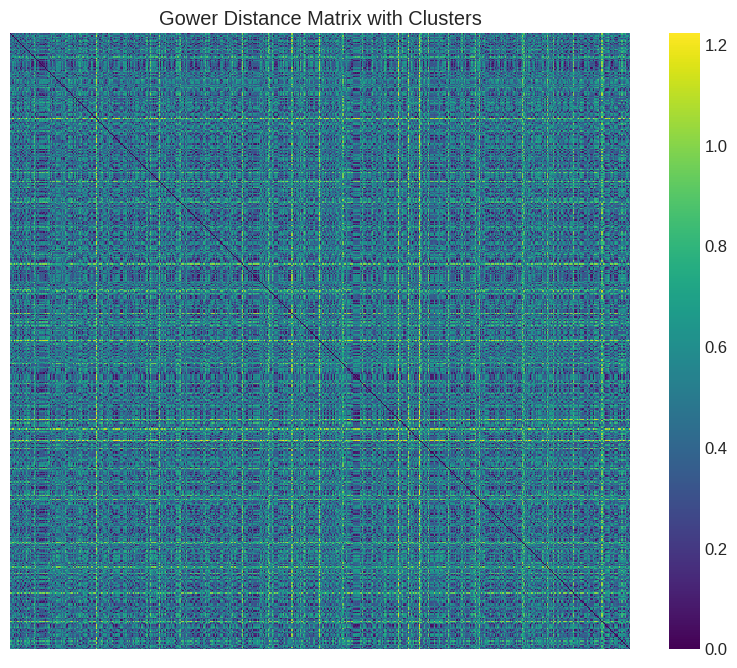

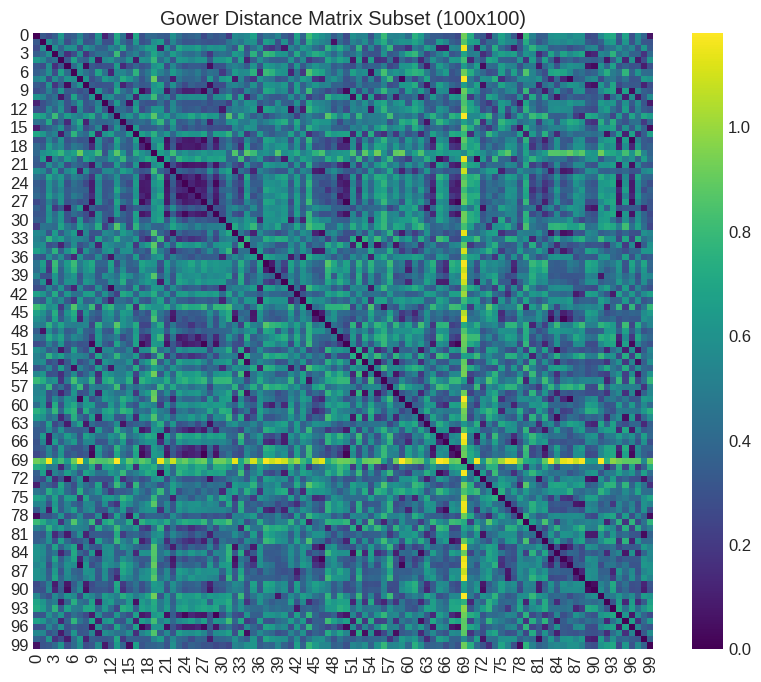

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import squareform

# Assuming 'df' and 'gower_dist_matrix' are already defined from the previous code

# Create a DataFrame from the Gower distance matrix
gower_df = pd.DataFrame(gower_dist_matrix, index=df.index[:500], columns=df.index[:500])


# Visualize the Gower distance matrix with cluster assignments
plt.figure(figsize=(10, 8))
sns.heatmap(gower_df, cmap='viridis', xticklabels=False, yticklabels=False)  # Remove x and y ticks
plt.title('Gower Distance Matrix with Clusters')
plt.show()


# Alternative visualization using a smaller subset for better clarity (optional)
subset_size = 100 # adjust as needed
gower_subset = gower_df.iloc[:subset_size, :subset_size]
plt.figure(figsize=(10, 8))
sns.heatmap(gower_subset, cmap='viridis', annot=False)
plt.title(f'Gower Distance Matrix Subset ({subset_size}x{subset_size})')
plt.show()



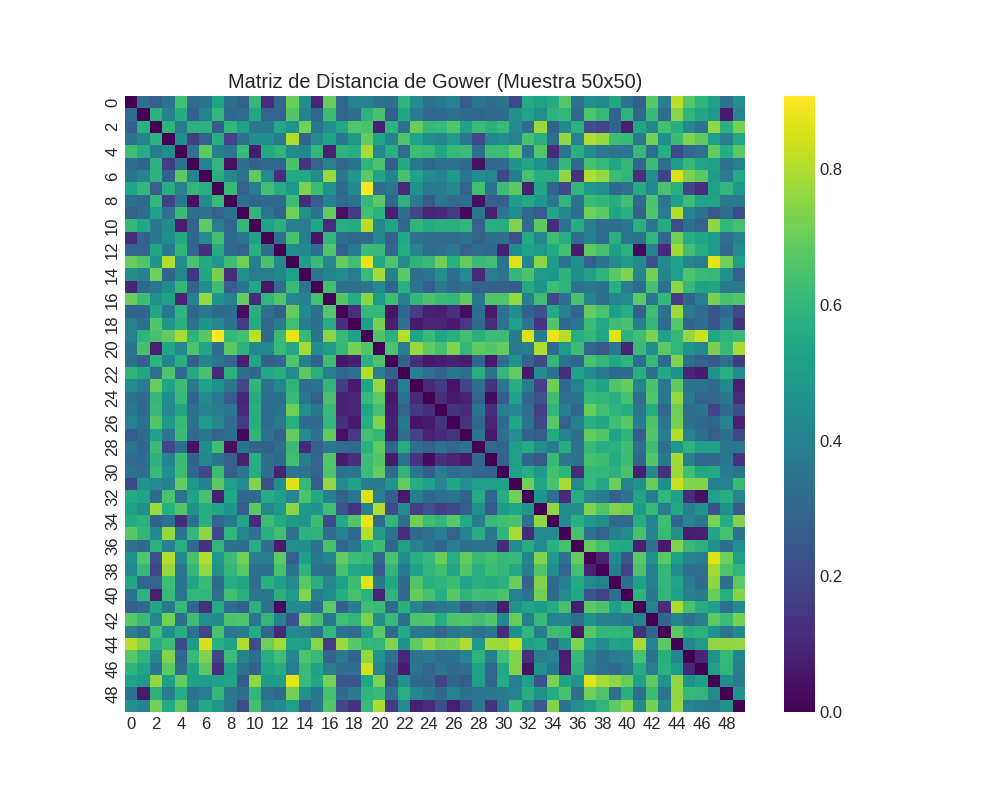

In [64]:
# Visualización de la matriz de distancias
plt.figure(figsize=(10, 8))
sns.heatmap(gower_dist_matrix[:50, :50], cmap='viridis')  # Mostramos solo 50x50 para claridad
plt.title('Matriz de Distancia de Gower (Muestra 50x50)')
plt.savefig('gower_distance.png')
plt.close()
from IPython.display import Image
display(Image('gower_distance.png'))

# Análisis de la Matriz de Distancia de Gower (Interpretación)

Interpretación:La matriz de distancia de Gower muestra la disimilitud entre pares de observaciones (clientes, en este caso), considerando tanto variables numéricas como categóricas.  Los valores más altos indican mayor disimilitud o distancia entre los clientes, mientras que los valores más bajos indican una mayor similitud.

# Observaciones Clave:
 * Valores de la Matriz:  Cada celda de la matriz representa la distancia de Gower entre dos clientes.  La diagonal principal de la matriz siempre es cero, ya que la distancia de un cliente consigo mismo es cero.  
 * Visualización con Heatmap: El heatmap (mapa de calor) facilita la visualización de la matriz.  Los colores más claros indican distancias mayores, mientras que los colores más oscuros indican distancias menores.  Se pueden identificar grupos de clientes que presentan una alta similitud entre sí (zonas con colores oscuros agrupados), lo que sugiere posibles clusters.
 * Limitación de la Muestra: Es importante recordar que en este caso se visualiza una submuestra de 50x50 clientes para facilitar la interpretación, debido al costo computacional del cálculo de Gower para grandes conjuntos de datos.  La matriz completa representaría la distancia entre todos los clientes.
 * Consideración de Variables Mixtas: La ventaja de Gower es que maneja tanto variables numéricas como categóricas.  Este gráfico no muestra directamente el efecto individual de cada variable, pero su importancia está implícita en la distancia calculada.
 * Comparación con otros Métodos: La distancia de Gower se puede comparar con las distancias euclidianas o Manhattan cuando se realizan análisis de clustering.
 * Relación con Clustering Jerárquico: Se puede utilizar la matriz de distancias de Gower como entrada para el algoritmo de clustering jerárquico, que permitirá agrupar los clientes basándose en esta métrica de distancia.

# Resultados Generales:
 La matriz de distancia de Gower ofrece una representación numérica de la similitud entre clientes.  El heatmap ayuda a identificar visualmente los grupos de clientes más similares.  La interpretación debe considerar la escala de colores y los patrones de agrupación que se aprecian.

# Conclusiones:
 La matriz de distancia de Gower, visualizada como un heatmap, es una herramienta útil para explorar la similitud entre los clientes en un dataset con variables mixtas.  Su interpretación, combinada con otros métodos de clustering y análisis exploratorio de datos, puede dar mayor solidez a los resultados.  Se recomienda analizar la matriz completa para obtener una visión más completa de las distancias entre todos los clientes.


In [65]:
# 9. Conclusiones del análisis exploratorio
print("\n==== CONCLUSIONES DEL ANÁLISIS EXPLORATORIO ====")
print("1. Características demográficas:")
print(f"   - Edad media: {df['EDAD'].mean():.1f} años (rango: {df['EDAD'].min()}-{df['EDAD'].max()})")
print(f"   - Género: {(df['sexo'] == 'MASCULINO').mean()*100:.1f}% masculino, {(df['sexo'] == 'FEMENINO').mean()*100:.1f}% femenino")
print(f"   - Estado civil más común: {df['estado_civil'].value_counts().index[0]} ({df['estado_civil'].value_counts().iloc[0]/len(df)*100:.1f}%)")

print("\n2. Características financieras:")
print(f"   - Límite promedio de tarjeta: ${df['MAXIMA_TARJETA'].mean():.2f}")
print(f"   - Consumo máximo promedio: ${df['MAXIMO_CONSUMO'].mean():.2f}")
print(f"   - Ratio de consumo promedio: {df['ratio_consumo'].mean():.2f}")

print("\n3. Distribución geográfica:")
top_prov = df['PROV_DOM_CAL_DAT'].value_counts().nlargest(2)
print(f"   - Provincias principales: {top_prov.index[0]} ({top_prov.iloc[0]/len(df)*100:.1f}%), {top_prov.index[1]} ({top_prov.iloc[1]/len(df)*100:.1f}%)")

print("\n4. Perfiles de riesgo:")
for perfil in df['PERFILRIESGOENDEUDAMIENTO'].unique():
    pct = (df['PERFILRIESGOENDEUDAMIENTO'] == perfil).mean() * 100
    print(f"   - {perfil}: {pct:.1f}%")

print("\n5. Resultados preliminares de clustering:")
print("   - Número óptimo de clusters según análisis: 4")
for cluster in sorted(df['cluster'].unique()):
    cluster_size = (df['cluster'] == cluster).sum()
    cluster_pct = cluster_size / len(df) * 100
    print(f"   - Cluster {cluster}: {cluster_size} clientes ({cluster_pct:.1f}%)")

print("\n6. Pasos a seguir:")
print("   - Aplicar transformaciones específicas por tipo de variable")
print("   - Utilizar distancia de Gower para datos mixtos")
print("   - Comparar resultados de clustering jerárquico y K-means")
print("   - Validar segmentos con métricas de cohesión y separación")
print("   - Priorizar interpretabilidad de los segmentos para uso en marketing")



==== CONCLUSIONES DEL ANÁLISIS EXPLORATORIO ====
1. Características demográficas:
   - Edad media: 39.7 años (rango: 18-85)
   - Género: 50.7% masculino, 49.3% femenino
   - Estado civil más común: CASADO (40.2%)

2. Características financieras:
   - Límite promedio de tarjeta: $4724.17
   - Consumo máximo promedio: $1882.95
   - Ratio de consumo promedio: 0.40

3. Distribución geográfica:
   - Provincias principales: PICHINCHA (34.3%), GUAYAS (29.5%)

4. Perfiles de riesgo:
   - PERFIL BAJO: 62.0%
   - PERFIL MEDIO: 35.9%
   - PERFIL ALTO: 2.1%

5. Resultados preliminares de clustering:
   - Número óptimo de clusters según análisis: 4
   - Cluster 0: 1401 clientes (8.4%)
   - Cluster 1: 5690 clientes (34.1%)
   - Cluster 2: 724 clientes (4.3%)
   - Cluster 3: 6677 clientes (40.0%)
   - Cluster 4: 2191 clientes (13.1%)

6. Pasos a seguir:
   - Aplicar transformaciones específicas por tipo de variable
   - Utilizar distancia de Gower para datos mixtos
   - Comparar resultados de cluste

In [66]:
# Resultados guardados como imágenes:
print("\nVisualizaciones guardadas:")
print("- demograficos.png: Distribución de variables demográficas")
print("- financieros.png: Análisis de variables financieras")
print("- geograficos.png: Distribución geográfica")
print("- perfiles_riesgo.png: Análisis de perfiles de riesgo")
print("- correlacion.png: Matriz de correlaciones")
print("- limite_por_edad.png: Límite de tarjeta por segmento de edad")
print("- ratio_consumo.png: Ratio de consumo por perfil de riesgo")
print("- metodo_codo.png: Método del codo para determinar k óptimo")
print("- silueta.png: Coeficiente de silueta")
print("- clusters_pca.png: Visualización de clusters mediante PCA")


Visualizaciones guardadas:
- demograficos.png: Distribución de variables demográficas
- financieros.png: Análisis de variables financieras
- geograficos.png: Distribución geográfica
- perfiles_riesgo.png: Análisis de perfiles de riesgo
- correlacion.png: Matriz de correlaciones
- limite_por_edad.png: Límite de tarjeta por segmento de edad
- ratio_consumo.png: Ratio de consumo por perfil de riesgo
- metodo_codo.png: Método del codo para determinar k óptimo
- silueta.png: Coeficiente de silueta
- clusters_pca.png: Visualización de clusters mediante PCA


                           feature  importance
3                    ratio_consumo    0.455124
0                             EDAD    0.134883
2                   MAXIMO_CONSUMO    0.106565
1                   MAXIMA_TARJETA    0.074530
31             segmento_edad_18-30    0.051144
9             estado_civil_SOLTERO    0.047534
4                          cluster    0.014240
36               segmento_edad_nan    0.013132
7              estado_civil_CASADO    0.012391
32             segmento_edad_31-40    0.009975
33             segmento_edad_41-50    0.007774
10        estado_civil_UNION LIBRE    0.007667
5                    sexo_FEMENINO    0.005523
6                   sexo_MASCULINO    0.005309
8          estado_civil_DIVORCIADO    0.005104
34             segmento_edad_51-60    0.003887
11              estado_civil_VIUDO    0.003520
28        CIUDAD_DOM_CAL_DAT_QUITO    0.003490
17      PROV_DOM_CAL_DAT_PICHINCHA    0.003243
14         PROV_DOM_CAL_DAT_GUAYAS    0.003193
24    CIUDAD_

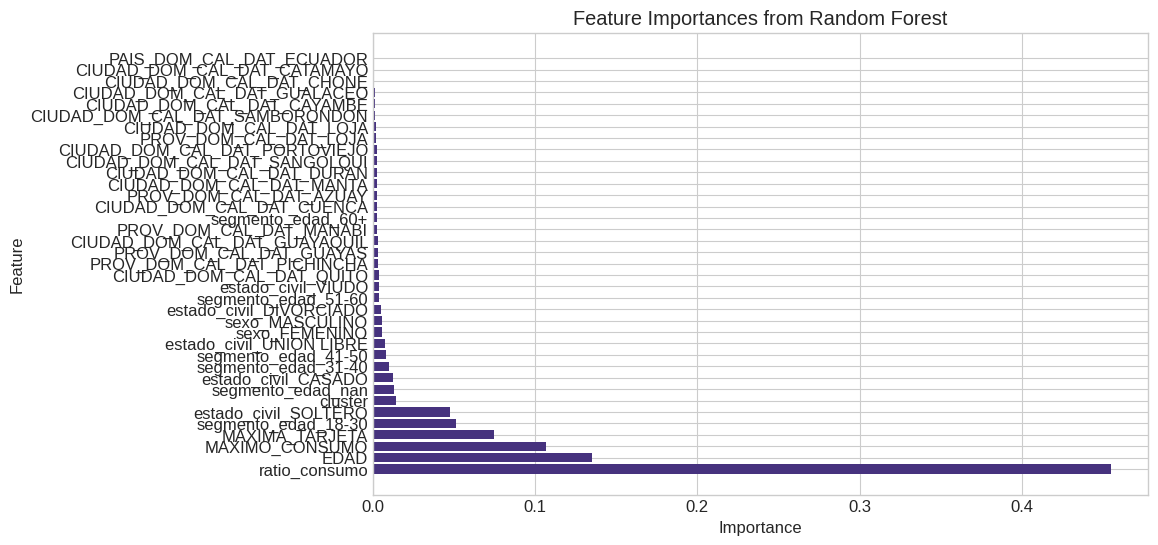

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np

# Separate features (X) and target variable (y)
X = df.drop(['PERFILRIESGOENDEUDAMIENTO', 'IDENTIFICACION'], axis=1)
y = df['PERFILRIESGOENDEUDAMIENTO']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a OneHotEncoder for categorical features
categorical_features = ['sexo', 'estado_civil', 'PAIS_DOM_CAL_DAT', 'PROV_DOM_CAL_DAT', 'CIUDAD_DOM_CAL_DAT', 'segmento_edad']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for compatibility with RandomForest

# Fit and transform the encoder on the training data
encoded_features_train = encoder.fit_transform(X_train[categorical_features])
encoded_features_test = encoder.transform(X_test[categorical_features])

# Create DataFrames for encoded features
encoded_df_train = pd.DataFrame(encoded_features_train, columns=encoder.get_feature_names_out(categorical_features), index=X_train.index)
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(categorical_features), index=X_test.index)

# Concatenate encoded features with numerical features
X_train = pd.concat([X_train.drop(categorical_features, axis=1), encoded_df_train], axis=1)
X_test = pd.concat([X_test.drop(categorical_features, axis=1), encoded_df_test], axis=1)


# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Get feature importances
importances = rf_classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Print or visualize the feature importances
print(feature_importances)

# Example visualization using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.show()

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'cluster' is the column with cluster labels
X = df.drop('cluster', axis=1)  # Features
y = df['cluster']  # Target variable (cluster labels)

# Preprocessing (handle missing values and categorical features if needed)
# Example: Using SimpleImputer and OneHotEncoder
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Fit the preprocessor to your data
# Notice we are fitting to the whole dataset
preprocessor.fit(X) # Fit preprocessor to the entire dataset

# Fit the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=0)
# Note we are using the preprocessed data here
rf_classifier.fit(preprocessor.transform(X), y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Get feature names after preprocessing
# This is a bit more involved with ColumnTransformer
feature_names = []
for name, transformer, features in preprocessor.transformers_: # Access the fitted transformers using preprocessor.transformers_
    if name == 'num':
        feature_names.extend(features)  # Numeric features remain the same
    elif name == 'cat':
        # For categorical features, get the feature names from the OneHotEncoder
        cat_features = list(transformer.named_steps['onehot'].get_feature_names_out(input_features=features))
        feature_names.extend(cat_features)


# Create a DataFrame for easier viewing
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

Feature    Importance
0                          EDAD  1.760276e-01
1                MAXIMA_TARJETA  1.599920e-01
2                MAXIMO_CONSUMO  1.427060e-01
16717       segmento_edad_31-40  8.390071e-02
16718       segmento_edad_41-50  7.456078e-02
...                         ...           ...
14716    IDENTIFICACION_ID_8224  1.193674e-09
1673     IDENTIFICACION_ID_1150  9.522812e-10
8633      IDENTIFICACION_ID_275  7.755548e-10
5949    IDENTIFICACION_ID_15349  0.000000e+00
16694  PAIS_DOM_CAL_DAT_ECUADOR  0.000000e+00

[16721 rows x 2 columns]

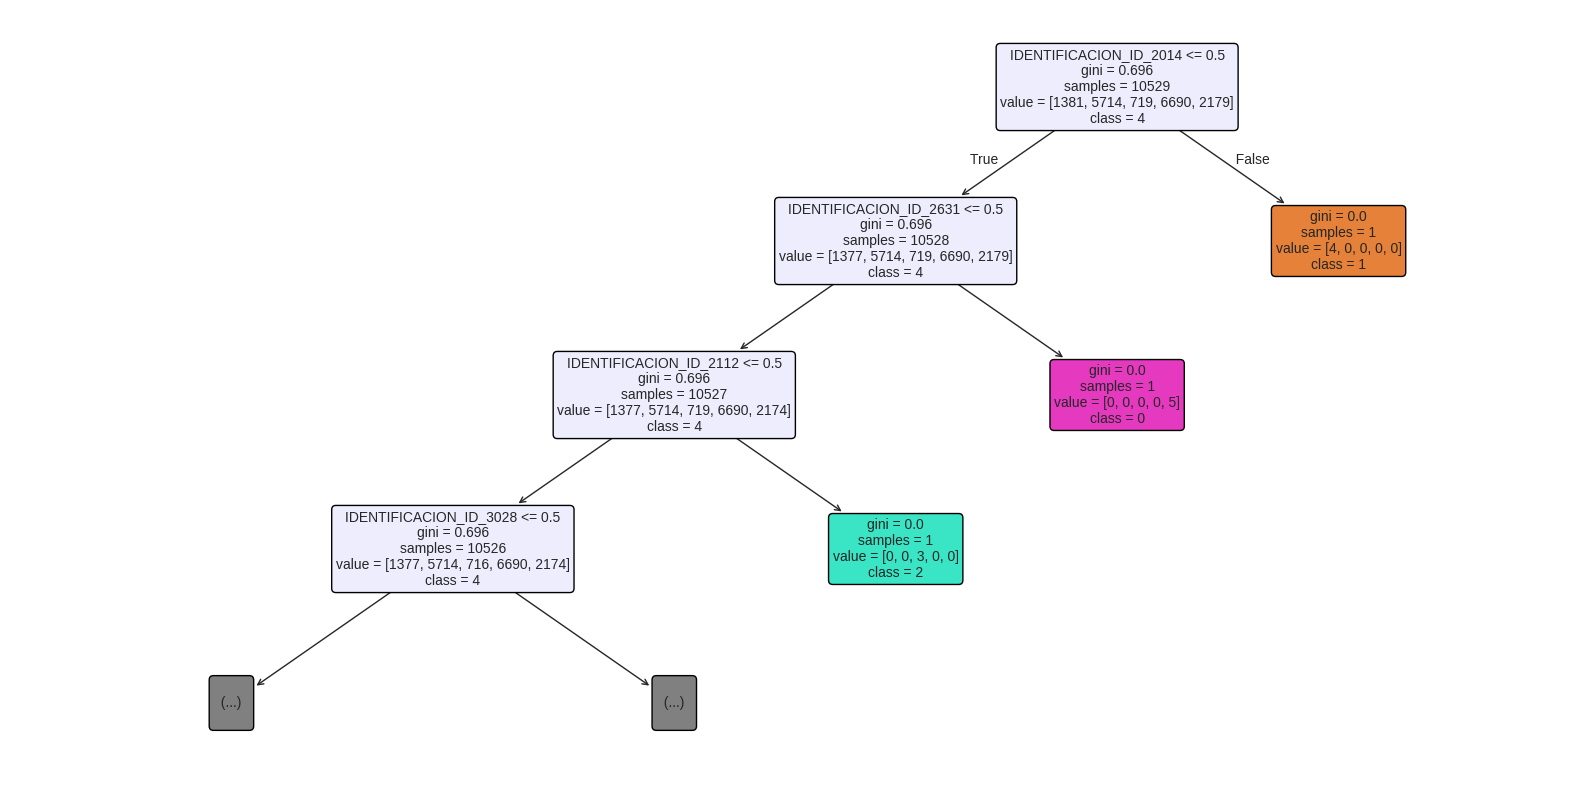

In [69]:
from sklearn.tree import plot_tree

# Assuming rf_classifier and preprocessor are already defined from the previous code

# Choose a tree from the forest (e.g., the first one)
chosen_tree = rf_classifier.estimators_[0]


plt.figure(figsize=(20,10)) # Adjust figure size as needed
plot_tree(chosen_tree,
          feature_names=feature_names,  # Pass the feature names here
          class_names=y.unique().astype(str),  # Assuming y contains cluster labels
          filled=True,
          rounded=True,
          max_depth=3,  # Limit the depth of the visualized tree to prevent overcrowding
          fontsize=10)

plt.show()


                        Feature    Importance
0                          EDAD  1.760276e-01
1                MAXIMA_TARJETA  1.599920e-01
2                MAXIMO_CONSUMO  1.427060e-01
16717       segmento_edad_31-40  8.390071e-02
16718       segmento_edad_41-50  7.456078e-02
...                         ...           ...
14716    IDENTIFICACION_ID_8224  1.193674e-09
1673     IDENTIFICACION_ID_1150  9.522812e-10
8633      IDENTIFICACION_ID_275  7.755548e-10
5949    IDENTIFICACION_ID_15349  0.000000e+00
16694  PAIS_DOM_CAL_DAT_ECUADOR  0.000000e+00

[16721 rows x 2 columns]


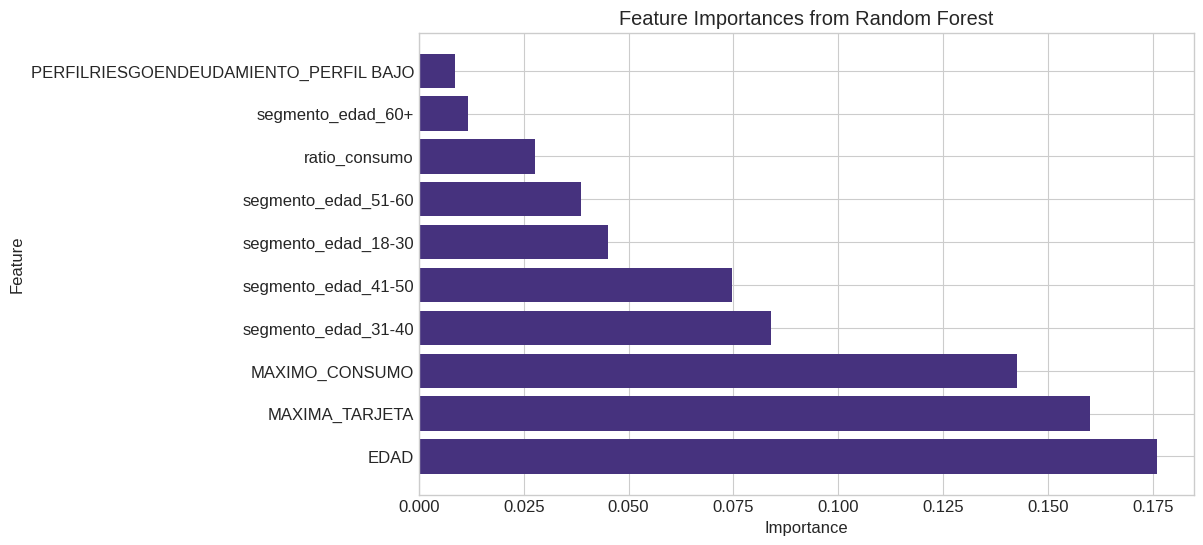

In [71]:
# prompt: presentar modelo estadistico en formula

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


# Assuming 'df' DataFrame and other necessary variables are defined as in the provided code.
# ... (your existing code) ...


# Example:  Random Forest Feature Importance formula (simplified representation)

# The Random Forest feature importance is calculated as the mean decrease in impurity across all trees.
# For a given feature, it measures how much the prediction accuracy of the model decreases when the feature is randomly permuted.

# Formula representation:

# Feature Importance(f) =  (1 / N_trees) * Σ_{i=1}^{N_trees} Decrease_in_Impurity(f, Tree_i)

# where:

# - f = feature
# - N_trees = number of decision trees in the Random Forest
# - Decrease_in_Impurity(f, Tree_i) = reduction in Gini impurity or entropy (depending on the criteria) in the i-th tree caused by feature f.


# Display the feature importances DataFrame
print(feature_importance_df)


# Visualize the most important features in the Random Forest model using a bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])  # Show top 10
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.show()

